In [6]:
%matplotlib inline

In [1]:
import numpy as np
import time
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import scipy.linalg as la

In [2]:
# Load Data
## Simulating Data
n = 1000
r = .95
inter = np.ones(n)
x1 = np.random.normal(0,5,n)
x2 = np.random.normal(0,2,n)
x34 = np.random.multivariate_normal([0, 0], np.array([[3, r], [r, 2]]), n)
X = np.c_[x1,x2,x34]
X = (X - X.mean(axis = 0)) / X.std(axis = 0)
X = np.c_[inter,X]

beta = np.array([1,-2,3,-1,2]).reshape(5,1)
pr = 1 / (1 + np.exp(-X.dot(beta)))

# Possibly need to standardize this
y = np.random.binomial(n=1, p=pr)

In [3]:
def matlab_lognorm(x,w,alpha):
    return np.sum(-(.5*np.log(2*np.pi*alpha)) - ((x - w)**2) / (2*alpha))

In [13]:
X = X
t = y
NumOfIterations = 6000
BurnIn = 1000
NumOfLeapFrogSteps = 6
StepSize = 3 / NumOfLeapFrogSteps
NumOfNewtonSteps = 4
n,D = X.shape
alpha = 100


In [14]:
w = np.ones((D,1))*1e-3
wSaved = np.zeros((NumOfIterations - BurnIn,D))
GDeriv = {}
InvGdG = {}

LogPrior = matlab_lognorm(np.zeros(D),w.reshape(D,),alpha)
f = X.dot(w)   
LogLikelihood = f.T.dot(t) - np.sum(np.log(1 + np.exp(f)))
CurrentLJL = LogLikelihood + LogPrior
Z2 = np.zeros((n,D))
TraceInvGdG = np.zeros(D)

for iteration in range(NumOfIterations):
    print("Iteration Num: ", iteration)
    #LogPrior = matlab_lognorm(np.zeros((1,D)),w,alpha)
    #LogPrior = matlab_lognorm(np.zeros((1,D)),w,alpha)
    #f = X.dot(w)   
    #LogLikelihood = f.T.dot(t) - np.sum(np.log(1 + np.exp(f)))
    #CurrentLJL = LogLikelihood + LogPrior


    wNew = w
    # Calculating G
    f = X.dot(wNew)
    p = 1 / (1 + np.exp(-f))
    v = p * (1 - p)
    #G = (X.T *  np.tile(v.T,(D,1))).dot(X) + np.eye(D) / alpha
    
    InvG = la.inv(G)
    OriginalG = G
    OriginalCholG = la.cholesky(G)
    OriginalInvG = InvG
    
    for d in range(D):
        Z = ((1 - 2*p)*(X[:,d]).reshape(-1,1))
        # Z = ((1 - 2*p)*(X[:,j]))
        Z1 = v*Z
        
        for a in range(D):
            Z2[:,a] = (X[:,a].reshape(-1,1)*Z1).reshape(n,)
        GDeriv[d] = Z2.T.dot(X)
        InvGdG[d] = InvG.dot(GDeriv[d])
        TraceInvGdG[d] = np.trace(InvGdG[d])
        
    ProposedMomentum = np.random.randn(1,D).dot(OriginalCholG).T
    OriginalMomentum = ProposedMomentum
    
    #if np.random.randn(1) > .5:
    #    TimeStep = 1
    #else:
    #    TimeStep = -1
            
    
    RandomSteps = np.ceil(np.random.rand(1)*NumOfLeapFrogSteps)
    
    SavedSteps = wNew
    
    # Leapfrog Steps
    for StepNum in np.arange(RandomSteps):
        
        # Update Momentum
        dLdTheta = (X.T.dot(t - 1 /(1 + np.exp(-f)))) - (np.identity(D)*(1/alpha)).dot(wNew)
        TraceTerm = .5*TraceInvGdG.T
        LastTerm = np.zeros(D)
        PM = ProposedMomentum
        MomentumHist = np.zeros((NumOfNewtonSteps,D))
        for FixedIter in range(NumOfNewtonSteps):
            MomentumHist[FixedIter,:] = PM.reshape(D,)
            InvGMomentum = InvG.dot(PM)
            for d in range(D):
                LastTerm[d] = .5*(PM.T.dot(InvGdG[d].dot(InvGMomentum)))
            PM = ProposedMomentum +(StepSize/2)*(dLdTheta - TraceTerm.reshape(D,-1) + LastTerm.T.reshape(D,-1))
        ProposedMomentum = PM
        # Update W parameters
        OriginalInvGMomentum = la.inv(G).dot(ProposedMomentum)
        Pw = wNew
        wHist = np.zeros((NumOfNewtonSteps,D))
        for FixedIter in range(NumOfNewtonSteps):
            #print("Iteration #: ",FixedIter)
            wHist[FixedIter,:] = Pw.reshape(D,)
            
            f = X.dot(Pw)
            #print("f: ",f[:10].T)
            p = 1 / (1 + np.exp(-f))
            #print("p: ", p[:10].T)
            v = p * (1 - p)
            #print("v: ",v[:10].T)
            G = (X.T *  np.tile(v.T,(D,1))).dot(X) + np.eye(D) / alpha
            #print("G: ",G)
            InvGMomentum = la.inv(G).dot(ProposedMomentum)
            Pw = wNew +  (StepSize/2) *(OriginalInvGMomentum + InvGMomentum)
            # IF the time step doesn't work, I will change this.
        wNew = Pw
        
        # Calculate G based on the new parameters
        f = X.dot(Pw)
        p = 1 / (1 + np.exp(-f))    
        v = p * (1 - p)
        G = (X.T *  np.tile(v.T,(D,1))).dot(X) + np.eye(D) / alpha
        
        InvG = la.inv(G)
        
        # Calculate Partial Derivatives for DG/dw
        for d in range(D):
            Z = ((1 - 2*p)*(X[:,d]).reshape(-1,1))
            # Z = ((1 - 2*p)*(X[:,j]))
            Z1 = v*Z
        
            for a in range(D):
                Z2[:,a] = (X[:,a].reshape(-1,1)*Z1).reshape(n,)
            GDeriv[d] = Z2.T.dot(X)
            InvGdG[d] = InvG.dot(GDeriv[d])
            TraceInvGdG[d] = np.trace(InvGdG[d])
        # Update Momentum
        f = X.dot(wNew)
        InvGMomentum = InvG.dot(ProposedMomentum)
        for d in range(D):
            LastTerm[d] = .5*((ProposedMomentum.T.dot(InvGdG[d].dot(InvGMomentum) )))
        dHdTheta = - (X.T.dot(t - (1 / (1 + np.exp(-f))))) - (np.eye(D)*(1/alpha)).dot(wNew) - .5 * TraceInvGdG.T.reshape(D,-1) + LastTerm.T.reshape(D,-1)
        ProposedMomentum = ProposedMomentum - (StepSize/2)*dHdTheta
        SavedSteps = np.r_[SavedSteps,wNew]
        if(StepNum == (RandomSteps - 1)):
            print("wNew: ",wNew.T)
        #(X.T.dot(t - 1 /(1 + np.exp(-f)))) - (np.identity(D)*(1/alpha)).dot(wNew)
        
    LogPrior = matlab_lognorm(np.zeros(D),wNew.reshape(D,),alpha)
    f = X.dot(wNew)
    LogLikelihood = f.T.dot(t) - np.sum(np.log(1 + np.exp(f)))    
    ProposedLJL = LogLikelihood + LogPrior
    
    #print("Proposed LJL: ", ProposedLJL, "Current LJL: ", CurrentLJL)
    ProposedLogDet = .5*(np.log(2) + D * np.log(np.pi) + 2 * np.sum(np.log(np.diag(la.cholesky(G)))))
    #print("Proposed LogDet: ", ProposedLogDet)
    ProposedH = -ProposedLJL + ProposedLogDet + (ProposedMomentum.T.dot(InvG.dot(ProposedMomentum))) / 2
    #print("Proposed H: ", ProposedH)
    # Current H value
    CurrentLogDet = .5* (np.log(2) + D * np.log(np.pi) + 2 * np.sum(np.log(np.diag(OriginalCholG))))
    
    CurrentH = - CurrentLJL + CurrentLogDet + (OriginalMomentum.T.dot(OriginalInvG.dot(OriginalMomentum)))/2
    
    Ratio = -ProposedH + CurrentH
    print
    #print("ProposedH: ", ProposedH," CurrentH: ",CurrentH)
    #print("Ratio: ", Ratio)
    
    u = np.log(np.random.rand(1))
    print("Ratio: ",Ratio," u: ",u)
    if (Ratio > 0 or Ratio > u):
        
        CurrentLJL = ProposedLJL
        w = wNew
        
    if iteration > BurnIn:
        wSaved[iteration-BurnIn,:] = w.reshape(5,)
    #print(w.T)
    # Update Moment
    #f = X.dot(wNew) # Already havee
    #InvGMomentum = InvG.dot(ProposedMomentum)    
    
        # When I do the saved steps later just do the np.r_[SavedSteps,new]
    # It's not updating.  all of these proposed WNew should be more likely
    # Yet None of them are being accpted.
    

Iteration Num:  0
wNew:  [[-17555508.21955267  78010277.23969114 -98745491.23029214
    8779998.97734502 -50212930.08424154]]
Ratio:  [[-inf]]  u:  [-2.5941034]
Iteration Num:  1
wNew:  [[ 0.20878491 -0.33091229  0.56389391 -0.20106592  0.40136047]]
Ratio:  [[-84.90535414]]  u:  [-0.52509326]
Iteration Num:  2
wNew:  [[ 0.78956191 -1.35169847  1.93539327 -0.70376584  1.60469272]]
Ratio:  [[-6487.28734675]]  u:  [-1.24840899]
Iteration Num:  3
wNew:  [[-2.14672675e+09  4.44393964e+09 -7.47377218e+09 -4.45997076e+08
  -4.50920020e+09]]
Ratio:  [[-inf]]  u:  [-0.57004832]
Iteration Num:  4
wNew:  [[ 0.0194863  -0.11621932  0.10829862 -0.15087159  0.15547674]]
Ratio:  [[1.45157813]]  u:  [-0.40341388]
Iteration Num:  5
wNew:  [[ 1.07976873 -1.65962141  2.58213356 -0.94468949  1.37468612]]
Ratio:  [[-9025.34702715]]  u:  [-0.77374858]
Iteration Num:  6
wNew:  [[ 0.04198368 -0.25313203  0.16091907 -0.16859714  0.25298486]]
Ratio:  [[0.42413514]]  u:  [-2.68511733]
Iteration Num:  7
wNew:  [[

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:97: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:119: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:128: RuntimeWarning: overflow encountered in exp


Ratio:  [[-1.29148139]]  u:  [-0.87074059]
Iteration Num:  17
wNew:  [[-2.24091660e+14  6.65646505e+14 -6.80005047e+14  1.84210376e+13
  -2.92480893e+14]]
Ratio:  [[-inf]]  u:  [-0.23316604]
Iteration Num:  18
wNew:  [[ 0.15252389 -0.4092875   0.25554986 -0.15640616  0.34186803]]
Ratio:  [[0.49103753]]  u:  [-0.23816399]
Iteration Num:  19
wNew:  [[-20305734.1752634   55364738.60658646 -85182134.10892366
    -739398.75829134 -47036551.52917752]]
Ratio:  [[-inf]]  u:  [-1.00240268]
Iteration Num:  20
wNew:  [[-7.57951138e+25  1.76574423e+26 -5.71173224e+25 -7.67811485e+24
  -2.83466833e+25]]
Ratio:  [[-inf]]  u:  [-0.0358204]
Iteration Num:  21
wNew:  [[ 0.84068467 -1.52527542  1.87858409 -0.47489396  1.29555544]]
Ratio:  [[-1496.03527217]]  u:  [-2.45993317]
Iteration Num:  22
wNew:  [[ 0.97014089 -2.43823329  3.06229196 -1.17995539  2.09817228]]
Ratio:  [[-11497.53912341]]  u:  [-2.7787888]
Iteration Num:  23
wNew:  [[ 0.41387294 -0.74786167  0.69955794 -0.31319417  0.72309931]]
Ratio

Ratio:  [[-inf]]  u:  [-0.45302312]
Iteration Num:  80
wNew:  [[ 0.69302612 -1.13580085  1.44506286 -0.64448704  1.21329755]]
Ratio:  [[-18.07032659]]  u:  [-0.53199684]
Iteration Num:  81
wNew:  [[ 0.59746112 -0.78576487  1.18775891 -0.35289288  0.88540576]]
Ratio:  [[-0.46044957]]  u:  [-0.7402613]
Iteration Num:  82
wNew:  [[-1.52140781e+24  3.49338291e+24 -1.35210717e+24 -1.53673795e+24
  -8.90749728e+23]]
Ratio:  [[-inf]]  u:  [-0.78034075]
Iteration Num:  83
wNew:  [[ 0.74878336 -0.89603698  1.2749995  -0.44951119  0.94215075]]
Ratio:  [[-1.76313577]]  u:  [-0.18935005]
Iteration Num:  84
wNew:  [[2.05917061e+28 4.92286976e+28 1.42217986e+28 3.76108197e+28
  4.73544793e+28]]
Ratio:  [[-inf]]  u:  [-0.21389334]
Iteration Num:  85
wNew:  [[ 4.46218317e+20 -5.02692975e+20 -3.37597762e+20  2.24421021e+20
  -1.99005819e+20]]
Ratio:  [[-inf]]  u:  [-1.56915071]
Iteration Num:  86
wNew:  [[ 1.19511555e+30  8.33413501e+29 -2.30058192e+30 -1.48309350e+30
  -1.07655069e+30]]
Ratio:  [[-inf

wNew:  [[ 365.71342077 -813.782792   1046.09189091 -379.3348041   629.49038945]]
Ratio:  [[-inf]]  u:  [-0.5218655]
Iteration Num:  153
wNew:  [[ 0.86666377 -1.55142569  2.32275261 -0.91995497  1.51310898]]
Ratio:  [[-30.83461022]]  u:  [-0.1445938]
Iteration Num:  154
wNew:  [[ 0.73185201 -1.25771406  1.60441266 -0.53389271  1.25578337]]
Ratio:  [[-0.46974995]]  u:  [-0.65333125]
Iteration Num:  155
wNew:  [[ 0.77097946 -1.56717367  1.97619959 -0.61847658  1.50843711]]
Ratio:  [[-4.48382203]]  u:  [-2.5067424]
Iteration Num:  156
wNew:  [[ 0.79473678 -1.3933273   1.79169388 -0.66702941  1.41433124]]
Ratio:  [[-1.58427991]]  u:  [-0.20413508]
Iteration Num:  157
wNew:  [[ 1.27251996 -2.11483279  2.73275111 -1.31230503  2.27417502]]
Ratio:  [[-62.60970625]]  u:  [-0.79215642]
Iteration Num:  158
wNew:  [[ 1.44590521 -1.77488685  2.77349009 -0.96086396  1.89753437]]
Ratio:  [[-46.97088013]]  u:  [-1.79056221]
Iteration Num:  159
wNew:  [[ 2.31469765e+32 -2.01442747e+32 -7.33771164e+32 -4

wNew:  [[ 2.35233424 -3.76765953  6.12137669 -2.05759995  4.20510829]]
Ratio:  [[-53.30818981]]  u:  [-0.56495389]
Iteration Num:  221
wNew:  [[ 1.05738972 -2.22345     2.99399553 -0.92285783  1.89511709]]
Ratio:  [[-5.63249939]]  u:  [-0.50121646]
Iteration Num:  222
wNew:  [[ 0.96815633 -2.00467795  2.60547674 -1.01714838  1.77629912]]
Ratio:  [[-1.71713291]]  u:  [-0.25622409]
Iteration Num:  223
wNew:  [[ 1.05113566 -1.81753126  2.30228964 -0.9952227   1.6799703 ]]
Ratio:  [[-0.32164272]]  u:  [-2.19513943]
Iteration Num:  224
wNew:  [[ 1.09943244 -1.8343593   2.3660979  -1.09037529  1.71024656]]
Ratio:  [[0.00067496]]  u:  [-0.21472589]
Iteration Num:  225
wNew:  [[ 1.25051315 -2.66271825  3.46722442 -0.98601968  2.33240041]]
Ratio:  [[-6.72703875]]  u:  [-3.60636334]
Iteration Num:  226
wNew:  [[ 1.68894501 -2.93113312  4.47736127 -1.28847073  3.01890361]]
Ratio:  [[-13.99207554]]  u:  [-1.47668673]
Iteration Num:  227
wNew:  [[ 1.04279697 -1.90926449  2.43812097 -1.17560005  1.7

wNew:  [[ 1.14723554 -1.80795522  2.89246625 -1.08328453  1.80278953]]
Ratio:  [[-0.19070181]]  u:  [-1.3448936]
Iteration Num:  286
wNew:  [[ 1.22205222 -2.12980533  2.97968635 -0.97552907  2.08806326]]
Ratio:  [[-1.15110686]]  u:  [-0.63595694]
Iteration Num:  287
wNew:  [[ 1.43868667 -2.75790931  3.18720459 -1.29296854  2.63193631]]
Ratio:  [[-2.8279668]]  u:  [-0.75260743]
Iteration Num:  288
wNew:  [[ 1.63907538 -2.58225884  3.17370003 -1.08879979  2.45449623]]
Ratio:  [[-3.88598678]]  u:  [-2.95513991]
Iteration Num:  289
wNew:  [[ 1.09993673 -1.83480486  2.8846039  -1.09148391  1.72505057]]
Ratio:  [[-0.04647939]]  u:  [-0.96483257]
Iteration Num:  290
wNew:  [[ 1.21992385 -2.32164974  3.01088854 -1.09595281  1.9949706 ]]
Ratio:  [[-0.88443774]]  u:  [-0.31149808]
Iteration Num:  291
wNew:  [[ 1.08114545 -1.7482434   2.69455972 -1.20617462  1.88462935]]
Ratio:  [[-0.0036942]]  u:  [-0.91959392]
Iteration Num:  292
wNew:  [[ 1.56329615 -2.93732872  3.55102153 -1.16201927  2.58935

Ratio:  [[-0.07359624]]  u:  [-0.45016434]
Iteration Num:  351
wNew:  [[ 1.55002867 -2.21641597  3.17881611 -1.20408796  2.31196086]]
Ratio:  [[-0.59402082]]  u:  [-0.63625127]
Iteration Num:  352
wNew:  [[ 0.99013111 -2.08985945  2.79919338 -1.19869969  2.08215721]]
Ratio:  [[0.43363892]]  u:  [-0.34792687]
Iteration Num:  353
wNew:  [[ 1.56936413 -2.28745537  3.23735827 -1.13092627  2.20039401]]
Ratio:  [[-1.28037829]]  u:  [-0.0242449]
Iteration Num:  354
wNew:  [[ 1.18130409 -2.17588743  2.65515507 -1.04199427  2.15265682]]
Ratio:  [[-0.09359334]]  u:  [-0.34986146]
Iteration Num:  355
wNew:  [[ 1.38637093 -2.31250141  3.55890389 -1.44454055  2.23225844]]
Ratio:  [[-1.64112295]]  u:  [-0.5045765]
Iteration Num:  356
wNew:  [[ 1.24726433 -2.53180887  2.70243102 -1.18254989  2.22190157]]
Ratio:  [[-0.81071026]]  u:  [-0.28271922]
Iteration Num:  357
wNew:  [[ 1.35429453 -2.20605353  3.33980731 -1.28769265  2.09469022]]
Ratio:  [[-0.36247195]]  u:  [-0.02205365]
Iteration Num:  358
wN

Ratio:  [[-0.2027899]]  u:  [-1.09284552]
Iteration Num:  414
wNew:  [[ 1.44639827 -2.58689289  3.50988729 -1.37685801  2.58370441]]
Ratio:  [[-0.26222541]]  u:  [-0.44838388]
Iteration Num:  415
wNew:  [[ 1.10142883 -1.86915694  2.56305642 -0.98723328  1.78735289]]
Ratio:  [[1.39645008]]  u:  [-0.60924783]
Iteration Num:  416
wNew:  [[ 1.40627311 -2.15673524  3.01115427 -1.15479406  2.36773976]]
Ratio:  [[-0.84185809]]  u:  [-1.89194785]
Iteration Num:  417
wNew:  [[ 1.34513519 -2.64185833  3.19982967 -1.54092627  2.10202751]]
Ratio:  [[-1.90453372]]  u:  [-0.05725465]
Iteration Num:  418
wNew:  [[ 1.26763251 -2.41651178  2.96897468 -1.16508195  2.35386257]]
Ratio:  [[-0.01931732]]  u:  [-0.36244642]
Iteration Num:  419
wNew:  [[ 1.44576545 -2.33803982  3.33642564 -1.42117706  2.36846035]]
Ratio:  [[-0.12971776]]  u:  [-5.06555177]
Iteration Num:  420
wNew:  [[ 1.44859162 -2.12869364  3.04027196 -1.38383096  2.4208119 ]]
Ratio:  [[0.00657072]]  u:  [-3.95735022]
Iteration Num:  421
wN

wNew:  [[ 1.45855075 -2.27200168  3.3443254  -1.5095548   2.29586338]]
Ratio:  [[-0.92899865]]  u:  [-0.42048739]
Iteration Num:  482
wNew:  [[ 1.25173568 -2.14341917  3.12858596 -1.32915536  2.32083838]]
Ratio:  [[-0.09214249]]  u:  [-0.66721659]
Iteration Num:  483
wNew:  [[ 1.1608558  -2.10197159  2.77595769 -0.92679988  1.77558159]]
Ratio:  [[0.46056363]]  u:  [-0.83699573]
Iteration Num:  484
wNew:  [[ 1.38912942 -2.30958337  3.22112143 -1.48878172  2.59498469]]
Ratio:  [[-1.52388514]]  u:  [-0.52291628]
Iteration Num:  485
wNew:  [[ 1.18308664 -2.09866201  2.99208335 -1.05958549  1.9580088 ]]
Ratio:  [[-0.63959688]]  u:  [-1.27185473]
Iteration Num:  486
wNew:  [[ 1.22380498 -2.07888321  3.03983843 -0.99310291  1.84425664]]
Ratio:  [[-0.11598728]]  u:  [-0.56965746]
Iteration Num:  487
wNew:  [[ 1.13741671 -2.01366131  2.63579332 -1.04514833  2.06500026]]
Ratio:  [[0.18349805]]  u:  [-1.03227369]
Iteration Num:  488
wNew:  [[ 1.1121672  -1.99647243  2.67612454 -0.99546376  2.0217

wNew:  [[ 1.31560233 -2.17355033  2.98801779 -1.20511086  2.17719744]]
Ratio:  [[0.08342563]]  u:  [-0.20442659]
Iteration Num:  547
wNew:  [[ 1.31027732 -2.22065559  3.14143459 -1.18713279  2.23465767]]
Ratio:  [[-0.08407615]]  u:  [-0.06046276]
Iteration Num:  548
wNew:  [[ 1.26619648 -2.09956826  2.99758525 -1.23162881  2.13937448]]
Ratio:  [[-0.0113232]]  u:  [-0.46760466]
Iteration Num:  549
wNew:  [[ 1.24938026 -2.31732715  2.87762132 -1.22301287  2.20685325]]
Ratio:  [[-0.17228758]]  u:  [-0.40523276]
Iteration Num:  550
wNew:  [[ 1.23844307 -2.04559302  3.05267995 -1.1039573   2.02791422]]
Ratio:  [[0.01707794]]  u:  [-0.32737924]
Iteration Num:  551
wNew:  [[ 1.15266826 -2.12287426  3.00256301 -1.11260199  1.98986145]]
Ratio:  [[0.00236295]]  u:  [-1.56066074]
Iteration Num:  552
wNew:  [[ 1.24037228 -2.26012081  3.06610582 -1.18086062  2.03880712]]
Ratio:  [[-0.12059099]]  u:  [-3.68794473]
Iteration Num:  553
wNew:  [[ 1.37084903 -2.38915383  3.08175591 -1.12928484  2.038936

wNew:  [[ 1.3090234  -2.40081397  2.99372785 -1.3859617   2.51710284]]
Ratio:  [[-0.70492784]]  u:  [-2.46342034]
Iteration Num:  612
wNew:  [[ 1.35310292 -2.25033161  3.06059985 -1.19364503  2.29386314]]
Ratio:  [[0.72156815]]  u:  [-0.34112039]
Iteration Num:  613
wNew:  [[ 1.21155005 -1.96926259  2.64038791 -0.99816892  1.77567983]]
Ratio:  [[0.69101673]]  u:  [-2.63084702]
Iteration Num:  614
wNew:  [[ 1.35084748 -2.72790909  3.45536281 -1.15072975  2.43189962]]
Ratio:  [[-2.21520511]]  u:  [-2.84223829]
Iteration Num:  615
wNew:  [[ 1.41172481 -2.86724926  3.71246433 -1.29970133  2.63667273]]
Ratio:  [[-0.43036036]]  u:  [-0.04120095]
Iteration Num:  616
wNew:  [[ 1.20288705 -1.7883424   2.64547485 -1.20134085  1.92019078]]
Ratio:  [[1.60676645]]  u:  [-1.35978827]
Iteration Num:  617
wNew:  [[ 1.3582107  -2.38493925  3.08805459 -1.08402843  2.20081999]]
Ratio:  [[-1.7827671]]  u:  [-0.35992918]
Iteration Num:  618
wNew:  [[ 1.32118882 -2.53153159  3.28123763 -1.09169286  2.331689

Ratio:  [[0.41303011]]  u:  [-2.44424113]
Iteration Num:  676
wNew:  [[ 0.99824683 -1.9672409   2.72747077 -0.85300618  1.96571362]]
Ratio:  [[-0.05423133]]  u:  [-2.55191545]
Iteration Num:  677
wNew:  [[ 1.04132888 -2.16579739  2.74313649 -0.87125939  2.11409144]]
Ratio:  [[-0.13109823]]  u:  [-0.86278902]
Iteration Num:  678
wNew:  [[ 1.53722267 -2.27397949  3.31174231 -1.52452268  2.17935494]]
Ratio:  [[-1.5718771]]  u:  [-1.28087616]
Iteration Num:  679
wNew:  [[ 1.1875664  -2.24429457  2.89272646 -1.00764246  2.12687913]]
Ratio:  [[0.07622964]]  u:  [-1.27113651]
Iteration Num:  680
wNew:  [[ 1.28380142 -2.23034987  3.29435181 -1.24295856  2.19775018]]
Ratio:  [[-0.18130323]]  u:  [-0.16004442]
Iteration Num:  681
wNew:  [[ 1.12269555 -2.19091143  2.90692384 -0.97737973  2.01228616]]
Ratio:  [[0.0574199]]  u:  [-0.07665647]
Iteration Num:  682
wNew:  [[ 1.08447416 -2.07018356  3.02714205 -0.97649496  2.05961832]]
Ratio:  [[-0.1742066]]  u:  [-0.37882209]
Iteration Num:  683
wNew:

wNew:  [[ 1.13794792 -1.92139295  2.81839759 -1.19736339  2.08931705]]
Ratio:  [[0.00396878]]  u:  [-0.36286425]
Iteration Num:  744
wNew:  [[ 1.38446009 -2.42438019  3.10426417 -1.13144922  2.13546488]]
Ratio:  [[-0.93028113]]  u:  [-0.58115883]
Iteration Num:  745
wNew:  [[ 0.92276473 -1.79587505  2.5683187  -1.1139948   1.86695684]]
Ratio:  [[0.04627906]]  u:  [-0.09572018]
Iteration Num:  746
wNew:  [[ 1.23247899 -2.3573948   2.93894489 -1.36223537  2.26809194]]
Ratio:  [[-1.66422607]]  u:  [-0.07843444]
Iteration Num:  747
wNew:  [[ 0.96230566 -1.88114     2.5362681  -1.02442993  1.83672509]]
Ratio:  [[0.04112703]]  u:  [-0.06425988]
Iteration Num:  748
wNew:  [[ 1.48362095 -2.17405497  3.09126258 -1.30529306  2.32766659]]
Ratio:  [[-1.28266862]]  u:  [-0.83956202]
Iteration Num:  749
wNew:  [[ 1.65245896 -2.61640612  3.60142163 -1.36688496  2.54360131]]
Ratio:  [[-1.83094037]]  u:  [-0.12624314]
Iteration Num:  750
wNew:  [[ 1.07395361 -1.79618344  2.61644085 -1.02346091  1.90221

wNew:  [[ 1.39790656 -2.58444827  3.60092484 -1.15167225  2.30065792]]
Ratio:  [[-2.05815719]]  u:  [-1.10540558]
Iteration Num:  810
wNew:  [[ 1.39769948 -2.13248919  3.23319497 -1.30117385  2.23718698]]
Ratio:  [[-0.65795842]]  u:  [-0.08294852]
Iteration Num:  811
wNew:  [[ 1.35229915 -2.50359845  3.56879892 -1.51910133  2.6643064 ]]
Ratio:  [[-1.94866723]]  u:  [-0.36722544]
Iteration Num:  812
wNew:  [[ 1.22350456 -2.12532658  2.80482706 -1.22822613  1.90424366]]
Ratio:  [[-0.23758618]]  u:  [-0.38735009]
Iteration Num:  813
wNew:  [[ 1.22102838 -1.99806395  2.78709218 -0.8476846   2.00640685]]
Ratio:  [[0.09271002]]  u:  [-0.46498921]
Iteration Num:  814
wNew:  [[ 1.43064601 -2.42318581  3.34445676 -1.61556404  2.33839315]]
Ratio:  [[-1.49412203]]  u:  [-1.28158749]
Iteration Num:  815
wNew:  [[ 1.25217454 -2.36200829  3.10862098 -1.3619669   2.16112216]]
Ratio:  [[-0.48331714]]  u:  [-0.05996861]
Iteration Num:  816
wNew:  [[ 1.34564201 -2.37312731  3.09516418 -1.52852278  2.122

wNew:  [[ 1.23968134 -2.16077952  2.92376909 -1.08130678  1.92551313]]
Ratio:  [[-0.00739647]]  u:  [-0.78975525]
Iteration Num:  878
wNew:  [[ 1.25854289 -2.18047717  3.00368915 -1.21439851  2.30144287]]
Ratio:  [[-0.01448099]]  u:  [-0.41149742]
Iteration Num:  879
wNew:  [[ 1.26798481 -2.12072114  2.91320175 -1.1385736   1.98276859]]
Ratio:  [[-0.03947711]]  u:  [-0.36935937]
Iteration Num:  880
wNew:  [[ 1.23788531 -2.32119175  3.03836011 -1.22619932  2.05615335]]
Ratio:  [[-0.48691517]]  u:  [-0.01056904]
Iteration Num:  881
wNew:  [[ 1.23973016 -2.21512262  2.99020643 -1.17690211  2.24884235]]
Ratio:  [[0.0494144]]  u:  [-0.75938598]
Iteration Num:  882
wNew:  [[ 1.33294488 -2.7067674   3.49532232 -1.60109375  2.54841209]]
Ratio:  [[-1.51278653]]  u:  [-2.50120655]
Iteration Num:  883
wNew:  [[ 1.22082481 -1.8257773   2.6177268  -0.84099542  1.8432    ]]
Ratio:  [[2.03416514]]  u:  [-0.35779058]
Iteration Num:  884
wNew:  [[ 1.30838317 -2.06947253  2.82501619 -0.9317183   1.92790

wNew:  [[ 1.22284885 -2.18577899  3.02701149 -1.26983382  1.94878796]]
Ratio:  [[0.10593983]]  u:  [-1.63201753]
Iteration Num:  943
wNew:  [[ 1.30243504 -2.18153595  2.92450612 -1.03532943  2.31029771]]
Ratio:  [[-0.13604924]]  u:  [-0.24401783]
Iteration Num:  944
wNew:  [[ 1.23494897 -2.24167628  3.23027485 -1.27083873  1.99675253]]
Ratio:  [[-0.22798694]]  u:  [-1.57191851]
Iteration Num:  945
wNew:  [[ 1.0959817  -2.00213761  2.98415242 -1.17988686  1.90007145]]
Ratio:  [[0.09356483]]  u:  [-0.25300445]
Iteration Num:  946
wNew:  [[ 1.42998448 -2.39845981  2.97838101 -1.14073357  2.38311841]]
Ratio:  [[-0.64513909]]  u:  [-0.53335316]
Iteration Num:  947
wNew:  [[ 1.45689377 -2.58190598  3.59030461 -1.26963095  2.29545155]]
Ratio:  [[-1.49896764]]  u:  [-1.68465665]
Iteration Num:  948
wNew:  [[ 1.09087267 -1.89780248  2.56275494 -1.12748827  2.03956198]]
Ratio:  [[1.08883555]]  u:  [-3.32585855]
Iteration Num:  949
wNew:  [[ 1.27451363 -1.90762612  2.6911678  -1.15485666  2.14421

wNew:  [[ 1.38122292 -2.22781107  3.10159565 -1.35824751  2.17151567]]
Ratio:  [[-0.04210682]]  u:  [-0.91067326]
Iteration Num:  1007
wNew:  [[ 1.24391735 -2.10072426  2.81998005 -1.10095701  1.98248079]]
Ratio:  [[1.09948472]]  u:  [-0.07434997]
Iteration Num:  1008
wNew:  [[ 1.24805032 -2.12206633  2.9016372  -1.18114911  2.08545956]]
Ratio:  [[0.0183202]]  u:  [-1.8942477]
Iteration Num:  1009
wNew:  [[ 1.35128696 -2.15691515  3.17757181 -1.17327584  1.98647541]]
Ratio:  [[-0.31186104]]  u:  [-1.70585547]
Iteration Num:  1010
wNew:  [[ 1.47271339 -2.27934365  3.34015335 -1.20277317  2.05099251]]
Ratio:  [[-0.18803912]]  u:  [-0.34645288]
Iteration Num:  1011
wNew:  [[ 1.4061043  -2.68973438  3.62816106 -1.43805855  2.40098271]]
Ratio:  [[-0.75618596]]  u:  [-1.47413432]
Iteration Num:  1012
wNew:  [[ 1.36102024 -2.39132839  3.38433927 -1.27433604  2.38422221]]
Ratio:  [[0.62642474]]  u:  [-1.16409168]
Iteration Num:  1013
wNew:  [[ 1.14174782 -2.26076909  3.17425133 -1.14480606  2.

wNew:  [[ 1.16590294 -2.08679693  2.85716403 -1.00291255  2.12726527]]
Ratio:  [[0.13826864]]  u:  [-0.80719859]
Iteration Num:  1076
wNew:  [[ 1.32613335 -2.12466507  2.93687068 -0.88681207  1.79061913]]
Ratio:  [[-0.08989766]]  u:  [-0.44151289]
Iteration Num:  1077
wNew:  [[ 1.26096288 -2.27636984  3.04347715 -1.03787606  1.83655072]]
Ratio:  [[-0.06009892]]  u:  [-1.806914]
Iteration Num:  1078
wNew:  [[ 1.22345591 -2.08863645  3.03451896 -1.15436175  2.33140206]]
Ratio:  [[-0.21135313]]  u:  [-0.41328761]
Iteration Num:  1079
wNew:  [[ 1.09098843 -2.19408196  2.81121377 -0.98793507  2.06231878]]
Ratio:  [[0.14004279]]  u:  [-0.33441979]
Iteration Num:  1080
wNew:  [[ 1.42778927 -2.17301332  3.15323439 -1.35481827  2.20102181]]
Ratio:  [[-0.18875653]]  u:  [-0.37507229]
Iteration Num:  1081
wNew:  [[ 1.09112801 -2.16322215  2.70906244 -1.01277754  1.96758653]]
Ratio:  [[0.24451756]]  u:  [-3.28347924]
Iteration Num:  1082
wNew:  [[ 1.07880485 -2.28632696  3.19216022 -1.21230998  2.

wNew:  [[ 1.36450244 -2.20495777  3.21464963 -1.36213833  2.32025788]]
Ratio:  [[-0.32772634]]  u:  [-1.30373644]
Iteration Num:  1138
wNew:  [[ 1.29421776 -2.12604186  2.87964216 -1.17662184  2.11439196]]
Ratio:  [[0.18367065]]  u:  [-0.08104927]
Iteration Num:  1139
wNew:  [[ 1.21681863 -2.19468963  2.8688094  -1.20329302  2.02227522]]
Ratio:  [[-0.00848783]]  u:  [-0.37056239]
Iteration Num:  1140
wNew:  [[ 1.13005804 -1.99586816  2.64305458 -0.92373393  1.83467963]]
Ratio:  [[0.1700561]]  u:  [-0.8454093]
Iteration Num:  1141
wNew:  [[ 1.10096755 -2.10510501  2.96518335 -1.02198073  2.1081163 ]]
Ratio:  [[-0.05197828]]  u:  [-0.2930112]
Iteration Num:  1142
wNew:  [[ 1.16567047 -2.04221375  3.02207848 -0.95686638  2.12871655]]
Ratio:  [[-0.13855527]]  u:  [-3.50544996]
Iteration Num:  1143
wNew:  [[ 1.10086724 -2.2078317   3.18625278 -1.21642294  2.27801141]]
Ratio:  [[-0.24729386]]  u:  [-2.74172579]
Iteration Num:  1144
wNew:  [[ 1.36762826 -2.19317393  2.90658648 -1.11698646  1.

wNew:  [[ 1.41279233 -2.24893736  2.98224062 -1.3543992   2.37473765]]
Ratio:  [[-0.41071586]]  u:  [-0.45122267]
Iteration Num:  1205
wNew:  [[ 1.36907511 -2.14910486  3.06739297 -1.09253352  2.07954088]]
Ratio:  [[0.16218889]]  u:  [-0.26008915]
Iteration Num:  1206
wNew:  [[ 1.11388245 -2.06584129  2.78132273 -0.88313214  1.86417477]]
Ratio:  [[0.25509707]]  u:  [-11.70596169]
Iteration Num:  1207
wNew:  [[ 1.20506516 -2.09311326  2.92404426 -1.33063545  2.26640082]]
Ratio:  [[-0.46470016]]  u:  [-1.06730841]
Iteration Num:  1208
wNew:  [[ 1.42207523 -2.34848827  3.06924962 -1.40706108  2.58189927]]
Ratio:  [[-0.69317481]]  u:  [-0.59722401]
Iteration Num:  1209
wNew:  [[ 1.2337048  -2.06680185  2.96403936 -1.30759291  2.18647969]]
Ratio:  [[0.03755512]]  u:  [-0.46655444]
Iteration Num:  1210
wNew:  [[ 1.39616571 -2.18429981  3.24073197 -1.33387122  2.380616  ]]
Ratio:  [[-0.16235774]]  u:  [-0.89841097]
Iteration Num:  1211
wNew:  [[ 1.30919125 -2.12451947  3.06511846 -1.20931863 

Ratio:  [[-0.01555146]]  u:  [-0.98331806]
Iteration Num:  1267
wNew:  [[ 1.27643877 -2.02360806  2.48457725 -0.93745658  1.72132235]]
Ratio:  [[-0.05793524]]  u:  [-1.59315444]
Iteration Num:  1268
wNew:  [[ 1.34941011 -2.36302528  3.36616185 -1.28461848  2.35034501]]
Ratio:  [[-2.09886904]]  u:  [-1.2308645]
Iteration Num:  1269
wNew:  [[ 1.36123825 -2.18719291  2.62615898 -1.0234496   1.82347982]]
Ratio:  [[-0.20462268]]  u:  [-0.54637263]
Iteration Num:  1270
wNew:  [[ 1.10386974 -2.22571357  3.30848353 -1.23343983  2.38210076]]
Ratio:  [[-1.24274296]]  u:  [-0.18958424]
Iteration Num:  1271
wNew:  [[ 1.13495412 -2.28752846  3.4721055  -1.37793547  2.56914381]]
Ratio:  [[-2.89451282]]  u:  [-0.0752014]
Iteration Num:  1272
wNew:  [[ 1.18049119 -2.08684726  2.58506836 -0.96913477  1.84818258]]
Ratio:  [[0.20959579]]  u:  [-3.03889632]
Iteration Num:  1273
wNew:  [[ 1.1892386  -1.90020641  2.72582876 -1.11180742  1.89244839]]
Ratio:  [[0.02663012]]  u:  [-2.10562058]
Iteration Num:  

Iteration Num:  1330
wNew:  [[ 1.29607295 -2.069834    2.86140586 -1.18078766  2.1701746 ]]
Ratio:  [[0.12542722]]  u:  [-0.0046057]
Iteration Num:  1331
wNew:  [[ 1.2795505  -2.45717095  3.32157844 -1.17511547  2.6533244 ]]
Ratio:  [[-1.45252093]]  u:  [-1.87102384]
Iteration Num:  1332
wNew:  [[ 1.22066726 -2.32157639  3.1125953  -1.08786285  2.34911241]]
Ratio:  [[0.51510814]]  u:  [-0.3283015]
Iteration Num:  1333
wNew:  [[ 1.32826165 -2.5666043   3.05643264 -0.87229017  2.34374514]]
Ratio:  [[-0.82032902]]  u:  [-1.32042535]
Iteration Num:  1334
wNew:  [[ 1.13360354 -1.83992181  2.7245769  -1.05102505  1.95156901]]
Ratio:  [[1.7257726]]  u:  [-0.4433759]
Iteration Num:  1335
wNew:  [[ 1.10448456 -1.90401302  2.75279878 -1.12376992  1.98892401]]
Ratio:  [[0.03456397]]  u:  [-2.06129394]
Iteration Num:  1336
wNew:  [[ 1.28958351 -1.89161586  2.69617176 -1.09100273  1.9832224 ]]
Ratio:  [[0.0323738]]  u:  [-0.17121105]
Iteration Num:  1337
wNew:  [[ 1.08194589 -1.94369983  2.65591693

wNew:  [[ 1.21943787 -2.18780107  3.35840582 -1.13857295  2.15361127]]
Ratio:  [[-0.38761838]]  u:  [-0.32718783]
Iteration Num:  1393
wNew:  [[ 1.22343506 -2.19287568  3.30911135 -1.14738233  2.14949117]]
Ratio:  [[-0.31126971]]  u:  [-0.24257973]
Iteration Num:  1394
wNew:  [[ 1.22423398 -2.39327662  3.0068895  -1.33452648  2.40231621]]
Ratio:  [[-0.54577529]]  u:  [-2.59594182]
Iteration Num:  1395
wNew:  [[ 1.49470765 -2.12942436  2.85940277 -1.15080943  2.00760745]]
Ratio:  [[0.24753547]]  u:  [-3.28390734]
Iteration Num:  1396
wNew:  [[ 1.21651185 -2.06401302  2.79884923 -0.8569499   1.77901372]]
Ratio:  [[0.43761933]]  u:  [-3.37899023]
Iteration Num:  1397
wNew:  [[ 1.1728758  -2.00192826  2.6806186  -1.05626286  2.08800616]]
Ratio:  [[-0.05748297]]  u:  [-0.50403459]
Iteration Num:  1398
wNew:  [[ 1.17100677 -2.24446609  2.86006416 -1.2069418   2.09125006]]
Ratio:  [[-0.19102915]]  u:  [-0.61110118]
Iteration Num:  1399
wNew:  [[ 1.377979   -2.07106163  3.01697855 -1.1759518  

wNew:  [[ 1.17866782 -2.1377259   2.72142227 -0.79000566  1.88403459]]
Ratio:  [[-0.47420732]]  u:  [-1.35542802]
Iteration Num:  1457
wNew:  [[ 1.0381731  -2.26719863  2.83365093 -0.84915472  1.98052393]]
Ratio:  [[-0.16779824]]  u:  [-0.66639409]
Iteration Num:  1458
wNew:  [[ 1.35676379 -2.24631147  3.22550131 -1.5268886   2.27821183]]
Ratio:  [[-2.29752016]]  u:  [-0.4427534]
Iteration Num:  1459
wNew:  [[ 1.25517381 -2.20635417  3.04142305 -1.18803787  2.21224751]]
Ratio:  [[-0.14443253]]  u:  [-0.36503927]
Iteration Num:  1460
wNew:  [[ 1.25195766 -2.13865337  2.89349855 -1.09503271  2.01794479]]
Ratio:  [[0.25207973]]  u:  [-0.41979056]
Iteration Num:  1461
wNew:  [[ 1.3103826  -2.69329458  3.69681419 -1.31446985  2.47002668]]
Ratio:  [[-2.19193124]]  u:  [-1.27164975]
Iteration Num:  1462
wNew:  [[ 1.16792213 -1.964246    2.72523092 -1.02170397  1.95532801]]
Ratio:  [[0.13770942]]  u:  [-1.11955988]
Iteration Num:  1463
wNew:  [[ 1.20318903 -1.98331199  2.78740581 -0.88218233  

wNew:  [[ 1.33043286 -2.01804141  2.76310225 -1.02573303  1.90989273]]
Ratio:  [[0.2648744]]  u:  [-0.05293636]
Iteration Num:  1520
wNew:  [[ 1.07830503 -2.19442607  3.09920893 -1.24956574  2.36090461]]
Ratio:  [[-1.04381761]]  u:  [-1.68107382]
Iteration Num:  1521
wNew:  [[ 1.25406694 -2.2342258   2.71478503 -0.96782802  1.92982819]]
Ratio:  [[0.33544164]]  u:  [-0.22419336]
Iteration Num:  1522
wNew:  [[ 1.35028808 -2.20353203  3.40752654 -1.35019518  2.35677797]]
Ratio:  [[-0.63547017]]  u:  [-0.37340826]
Iteration Num:  1523
wNew:  [[ 1.30822284 -2.3908598   3.42032778 -1.60939448  2.62223498]]
Ratio:  [[-2.10776782]]  u:  [-0.09497298]
Iteration Num:  1524
wNew:  [[ 1.33105163 -2.17115889  2.93602679 -1.4841718   2.46866448]]
Ratio:  [[-0.76891817]]  u:  [-2.01174726]
Iteration Num:  1525
wNew:  [[ 1.37835388 -2.2971302   3.01146258 -1.21823011  2.07300408]]
Ratio:  [[0.37195172]]  u:  [-0.35338849]
Iteration Num:  1526
wNew:  [[ 1.20919946 -2.40180351  2.80019649 -0.90693942  1

Iteration Num:  1586
wNew:  [[ 1.36031325 -2.36143946  3.09203744 -1.20936698  1.98647087]]
Ratio:  [[-0.72898933]]  u:  [-0.50728649]
Iteration Num:  1587
wNew:  [[ 1.23045961 -1.70521437  2.45479416 -1.14001428  1.95156944]]
Ratio:  [[0.06292125]]  u:  [-0.38227355]
Iteration Num:  1588
wNew:  [[ 1.3330515  -2.74627125  3.83797822 -1.31525915  2.48306435]]
Ratio:  [[-6.53475473]]  u:  [-0.15654794]
Iteration Num:  1589
wNew:  [[ 1.24807251 -1.85617138  2.66509886 -1.09713443  2.11478933]]
Ratio:  [[-0.12153673]]  u:  [-0.18753578]
Iteration Num:  1590
wNew:  [[ 1.31796521 -2.64830318  3.40007173 -1.26957691  2.19706476]]
Ratio:  [[-1.58197971]]  u:  [-0.59173869]
Iteration Num:  1591
wNew:  [[ 1.26789204 -2.57713754  3.54575584 -1.35903908  2.24147032]]
Ratio:  [[-1.82023051]]  u:  [-1.94168318]
Iteration Num:  1592
wNew:  [[ 1.22367487 -2.5913872   3.47574303 -1.28921144  2.25170722]]
Ratio:  [[0.04446851]]  u:  [-0.76857883]
Iteration Num:  1593
wNew:  [[ 1.25925333 -1.80764813  2.

Ratio:  [[-0.10286462]]  u:  [-0.97467137]
Iteration Num:  1648
wNew:  [[ 1.14868358 -2.07633093  2.57973136 -0.87803461  1.9375314 ]]
Ratio:  [[-0.56910216]]  u:  [-6.96860971]
Iteration Num:  1649
wNew:  [[ 1.09244738 -2.12323442  2.8314596  -0.97545088  1.97959392]]
Ratio:  [[-0.01387555]]  u:  [-5.32889527]
Iteration Num:  1650
wNew:  [[ 1.2191551  -2.30300888  3.08198202 -1.2458883   2.20275171]]
Ratio:  [[-0.19753292]]  u:  [-0.21749189]
Iteration Num:  1651
wNew:  [[ 1.23827723 -1.85004778  2.67997546 -1.03751104  1.92582657]]
Ratio:  [[0.68618897]]  u:  [-0.68847458]
Iteration Num:  1652
wNew:  [[ 1.09958768 -2.10729038  2.78483241 -1.02744164  2.00331323]]
Ratio:  [[-0.17645054]]  u:  [-0.05239823]
Iteration Num:  1653
wNew:  [[ 1.29045773 -2.66467063  3.36834184 -1.32396763  2.3841826 ]]
Ratio:  [[-1.67596641]]  u:  [-1.2116954]
Iteration Num:  1654
wNew:  [[ 1.26482675 -2.01238916  2.69275262 -1.07008127  2.02791042]]
Ratio:  [[0.07375123]]  u:  [-0.87143856]
Iteration Num: 

wNew:  [[ 1.41533024 -2.31744933  3.21227542 -1.46608086  2.37001066]]
Ratio:  [[-0.4214707]]  u:  [-0.86492719]
Iteration Num:  1713
wNew:  [[ 1.2541155  -2.1724211   3.09427726 -0.94940802  1.98135871]]
Ratio:  [[0.40321052]]  u:  [-2.08071962]
Iteration Num:  1714
wNew:  [[ 1.27959781 -2.2150085   2.87766076 -1.38334586  2.30246253]]
Ratio:  [[-0.01619819]]  u:  [-0.69019209]
Iteration Num:  1715
wNew:  [[ 1.08967084 -2.00740224  2.88530357 -1.10678731  2.04982789]]
Ratio:  [[0.21226723]]  u:  [-0.2047202]
Iteration Num:  1716
wNew:  [[ 1.3166995  -2.67186766  3.08828963 -1.26144109  2.10807478]]
Ratio:  [[-1.34757701]]  u:  [-1.24017263]
Iteration Num:  1717
wNew:  [[ 1.49296751 -2.61707689  3.07231529 -1.47156943  2.39196875]]
Ratio:  [[-1.57842521]]  u:  [-0.82278291]
Iteration Num:  1718
wNew:  [[ 1.1487239  -1.99200694  2.83855379 -1.01944211  1.99938761]]
Ratio:  [[0.03048395]]  u:  [-1.702145]
Iteration Num:  1719
wNew:  [[ 1.14255957 -1.93377873  2.64996033 -1.01159693  1.83

wNew:  [[ 1.30501448 -2.35688041  3.10983914 -1.03468277  1.98972052]]
Ratio:  [[-0.20366712]]  u:  [-0.15042821]
Iteration Num:  1779
wNew:  [[ 1.25082966 -2.15170111  2.90428466 -1.35557118  2.40244836]]
Ratio:  [[-0.1219218]]  u:  [-0.97009691]
Iteration Num:  1780
wNew:  [[ 1.24007335 -2.32934975  3.19489634 -1.15858982  2.00272149]]
Ratio:  [[0.00190935]]  u:  [-0.1430538]
Iteration Num:  1781
wNew:  [[ 1.3302629  -2.24452188  3.03255901 -1.43043946  2.42649172]]
Ratio:  [[-0.31450065]]  u:  [-2.07989812]
Iteration Num:  1782
wNew:  [[ 1.46223532 -2.3271001   3.17946282 -1.20557008  2.46595248]]
Ratio:  [[-0.29736153]]  u:  [-0.32771314]
Iteration Num:  1783
wNew:  [[ 1.49457363 -2.3632823   2.9918775  -1.19204336  2.41678732]]
Ratio:  [[0.01179659]]  u:  [-0.24939388]
Iteration Num:  1784
wNew:  [[ 1.04093164 -2.02867256  2.94958537 -1.15384456  1.88120251]]
Ratio:  [[0.91188866]]  u:  [-2.40747728]
Iteration Num:  1785
wNew:  [[ 1.17761864 -1.97173727  2.94622765 -1.0894136   1.

wNew:  [[ 1.0944823  -2.11936482  2.81118286 -0.80501569  1.88915313]]
Ratio:  [[-0.04138477]]  u:  [-0.08449616]
Iteration Num:  1847
wNew:  [[ 1.2997589  -2.13599093  3.04830248 -1.32574345  2.29064375]]
Ratio:  [[-0.46011709]]  u:  [-0.33428283]
Iteration Num:  1848
wNew:  [[ 1.39554382 -2.31719215  3.18753648 -1.51951553  2.34355184]]
Ratio:  [[-0.78334671]]  u:  [-0.37369589]
Iteration Num:  1849
wNew:  [[ 1.26127748 -2.17817224  2.85447122 -1.34925887  2.24321756]]
Ratio:  [[-1.09285227]]  u:  [-1.25674592]
Iteration Num:  1850
wNew:  [[ 1.48597374 -2.3551496   3.23815285 -1.15579708  2.29039721]]
Ratio:  [[-0.37042876]]  u:  [-1.25726789]
Iteration Num:  1851
wNew:  [[ 1.05949352 -2.02915122  2.71034048 -1.16170413  1.96771037]]
Ratio:  [[0.32647693]]  u:  [-3.37223937]
Iteration Num:  1852
wNew:  [[ 1.13669675 -2.31245489  3.08155418 -1.17418236  1.96745855]]
Ratio:  [[-0.24878922]]  u:  [-0.41702449]
Iteration Num:  1853
wNew:  [[ 1.2135758  -2.04475627  3.30718575 -0.91328146

wNew:  [[ 1.31863213 -2.43480765  3.13750599 -1.2842669   2.27247439]]
Ratio:  [[-0.02995594]]  u:  [-0.61191412]
Iteration Num:  1911
wNew:  [[ 1.16589661 -2.09043119  3.16982757 -1.06554586  2.13667425]]
Ratio:  [[-0.17425223]]  u:  [-1.07927471]
Iteration Num:  1912
wNew:  [[ 1.29355526 -2.26530996  3.18862235 -1.05643777  2.09856645]]
Ratio:  [[0.00275005]]  u:  [-0.07916162]
Iteration Num:  1913
wNew:  [[ 1.32035198 -2.26304363  3.32275063 -1.05859976  2.10440862]]
Ratio:  [[-0.12782699]]  u:  [-0.97081693]
Iteration Num:  1914
wNew:  [[ 1.36134993 -2.293674    3.14807553 -1.32410765  2.3708163 ]]
Ratio:  [[-0.07543071]]  u:  [-1.01779871]
Iteration Num:  1915
wNew:  [[ 1.1994234  -2.01433087  2.80598596 -1.01624743  1.8537599 ]]
Ratio:  [[-0.01714213]]  u:  [-0.63839373]
Iteration Num:  1916
wNew:  [[ 1.29998298 -2.11792392  2.9574133  -1.16368642  2.03676083]]
Ratio:  [[-0.31431235]]  u:  [-0.59418696]
Iteration Num:  1917
wNew:  [[ 1.13365174 -2.11643613  2.79821762 -0.96994899

Ratio:  [[-3.58308964]]  u:  [-1.33657572]
Iteration Num:  1983
wNew:  [[ 1.62077358 -2.43184437  3.50578365 -1.30679865  2.39221111]]
Ratio:  [[-3.78912556]]  u:  [-1.77042938]
Iteration Num:  1984
wNew:  [[ 1.21974801 -2.69487239  3.74564973 -1.37343989  2.58724958]]
Ratio:  [[-3.99120401]]  u:  [-1.02211951]
Iteration Num:  1985
wNew:  [[ 1.41763873 -2.17416795  2.93710808 -1.20398105  2.2434868 ]]
Ratio:  [[-0.54461231]]  u:  [-0.15558559]
Iteration Num:  1986
wNew:  [[ 1.36216044 -2.82416134  3.74119272 -1.27766363  2.59881161]]
Ratio:  [[-4.82434651]]  u:  [-0.15862276]
Iteration Num:  1987
wNew:  [[ 1.28126017 -2.07534321  2.97580306 -0.72758006  1.93078202]]
Ratio:  [[-1.56531289]]  u:  [-0.18382488]
Iteration Num:  1988
wNew:  [[ 1.19222286 -2.16734833  3.00134273 -1.09923203  2.2485416 ]]
Ratio:  [[-1.50115026]]  u:  [-0.03310714]
Iteration Num:  1989
wNew:  [[ 1.24588845 -2.42532646  3.37880196 -1.24182653  2.44531552]]
Ratio:  [[-2.99566431]]  u:  [-0.22006098]
Iteration Nu

wNew:  [[ 1.61440395 -2.30426069  3.57890317 -1.30426984  2.66577335]]
Ratio:  [[-3.1895733]]  u:  [-0.28829739]
Iteration Num:  2049
wNew:  [[ 1.16626459 -2.44334346  2.73995669 -1.11871954  1.9342711 ]]
Ratio:  [[-0.34580673]]  u:  [-0.49781705]
Iteration Num:  2050
wNew:  [[ 1.19567838 -1.75282563  2.96547438 -1.06317391  2.04148591]]
Ratio:  [[0.15066793]]  u:  [-0.15387613]
Iteration Num:  2051
wNew:  [[ 1.14431603 -1.86380782  2.78787626 -0.956091    1.89736457]]
Ratio:  [[0.2807476]]  u:  [-0.33632222]
Iteration Num:  2052
wNew:  [[ 1.18048598 -1.87247965  2.83081383 -1.07056035  1.96113713]]
Ratio:  [[0.00677115]]  u:  [-0.89436987]
Iteration Num:  2053
wNew:  [[ 1.35262165 -2.56047022  3.19542628 -1.28133689  2.35054905]]
Ratio:  [[-0.73356419]]  u:  [-0.26262965]
Iteration Num:  2054
wNew:  [[ 1.35221611 -2.41602608  3.33030795 -1.46642466  2.47457972]]
Ratio:  [[-1.13917303]]  u:  [-0.76743207]
Iteration Num:  2055
wNew:  [[ 1.52411749 -2.64375659  3.51847733 -1.13731769  2.

wNew:  [[ 1.28032682 -2.21530407  3.05563146 -1.08268116  2.2392716 ]]
Ratio:  [[0.0315357]]  u:  [-0.57249973]
Iteration Num:  2124
wNew:  [[ 1.21782418 -2.1305024   2.8341275  -1.20432712  1.98432092]]
Ratio:  [[0.00750726]]  u:  [-1.1307701]
Iteration Num:  2125
wNew:  [[ 1.19408618 -2.11964299  2.81599974 -1.17391425  1.96176542]]
Ratio:  [[-0.00514023]]  u:  [-0.25771917]
Iteration Num:  2126
wNew:  [[ 1.22326419 -2.07394173  2.98594274 -1.11546616  2.12916342]]
Ratio:  [[0.03155338]]  u:  [-0.38708247]
Iteration Num:  2127
wNew:  [[ 1.38912069 -2.22793314  3.11048857 -1.4146337   2.13577335]]
Ratio:  [[-0.35407549]]  u:  [-0.85524241]
Iteration Num:  2128
wNew:  [[ 1.04970146 -2.16415642  2.92875399 -0.90568428  2.03985284]]
Ratio:  [[0.22129961]]  u:  [-0.10868776]
Iteration Num:  2129
wNew:  [[ 1.03667373 -2.01627366  2.7776414  -1.13626598  1.91904901]]
Ratio:  [[0.34220023]]  u:  [-0.44296806]
Iteration Num:  2130
wNew:  [[ 1.50969279 -2.38530486  3.23095661 -1.16154825  2.38

wNew:  [[ 1.17045067 -2.13241128  3.03039466 -0.92672159  2.0867837 ]]
Ratio:  [[-0.07336361]]  u:  [-0.16422803]
Iteration Num:  2190
wNew:  [[ 1.08193129 -2.17407778  2.79036917 -1.15684445  2.1152218 ]]
Ratio:  [[0.1289965]]  u:  [-0.04146635]
Iteration Num:  2191
wNew:  [[ 1.41556455 -2.1401264   3.11296383 -1.14946601  2.10353119]]
Ratio:  [[-0.080124]]  u:  [-0.40210633]
Iteration Num:  2192
wNew:  [[ 1.09002747 -2.19800997  2.80661342 -1.13109241  2.1165708 ]]
Ratio:  [[0.08990276]]  u:  [-1.09422023]
Iteration Num:  2193
wNew:  [[ 1.08983509 -2.02876424  2.7386553  -1.16167176  2.03220594]]
Ratio:  [[0.19117694]]  u:  [-2.70509201]
Iteration Num:  2194
wNew:  [[ 1.08510619 -2.08814859  2.65081129 -1.11017499  2.00038267]]
Ratio:  [[-0.01330814]]  u:  [-0.00960109]
Iteration Num:  2195
wNew:  [[ 1.39240969 -2.11180255  2.97212067 -1.14737827  2.13233329]]
Ratio:  [[0.04433129]]  u:  [-2.69731473]
Iteration Num:  2196
wNew:  [[ 1.24425086 -2.36752623  3.18158429 -1.39873542  2.37

wNew:  [[ 1.4208286  -2.6918983   3.56189719 -1.61622822  2.31670534]]
Ratio:  [[-4.34552779]]  u:  [-1.16363736]
Iteration Num:  2254
wNew:  [[ 1.28139287 -2.13281149  3.22906874 -1.08035672  1.99161907]]
Ratio:  [[-1.18459694]]  u:  [-0.03573601]
Iteration Num:  2255
wNew:  [[ 1.36423055 -2.56826726  3.43069133 -1.53974883  2.25149916]]
Ratio:  [[-2.12500736]]  u:  [-0.88579635]
Iteration Num:  2256
wNew:  [[ 1.45286869 -2.32287452  2.95739403 -1.36194412  2.34581222]]
Ratio:  [[-1.53708782]]  u:  [-0.99427117]
Iteration Num:  2257
wNew:  [[ 1.35150061 -2.67040853  3.29558335 -1.57589203  2.20814511]]
Ratio:  [[-2.77048843]]  u:  [-0.33816981]
Iteration Num:  2258
wNew:  [[ 1.18239414 -2.00405114  2.80643111 -1.1100017   1.93659648]]
Ratio:  [[-0.12182232]]  u:  [-0.7363687]
Iteration Num:  2259
wNew:  [[ 1.3090034  -2.3140516   3.06345205 -1.18724143  2.26042771]]
Ratio:  [[-0.3312979]]  u:  [-1.03347765]
Iteration Num:  2260
wNew:  [[ 1.43701696 -1.97593871  2.80174351 -1.22769756 

wNew:  [[ 1.26392031 -2.18589333  2.82106966 -1.22845716  2.30903334]]
Ratio:  [[-0.54111823]]  u:  [-0.48085084]
Iteration Num:  2318
wNew:  [[ 1.28361852 -2.190034    3.01206749 -1.08557699  1.94801773]]
Ratio:  [[-0.02012478]]  u:  [-0.18989235]
Iteration Num:  2319
wNew:  [[ 1.2157872  -2.01021645  2.71217481 -0.80592732  1.73489283]]
Ratio:  [[0.02107074]]  u:  [-1.91972813]
Iteration Num:  2320
wNew:  [[ 1.50735328 -2.37002142  3.047405   -1.44791802  2.53198876]]
Ratio:  [[-3.5100573]]  u:  [-1.5508796]
Iteration Num:  2321
wNew:  [[ 1.19916824 -2.35600098  3.05770275 -1.21989074  2.30592859]]
Ratio:  [[-0.8764605]]  u:  [-0.16967007]
Iteration Num:  2322
wNew:  [[ 1.14221788 -2.11152974  2.96920314 -1.23218391  1.99499943]]
Ratio:  [[-0.49391862]]  u:  [-0.46325679]
Iteration Num:  2323
wNew:  [[ 1.31689932 -2.161758    3.21393649 -1.07217368  2.03729188]]
Ratio:  [[-0.46537451]]  u:  [-0.37729483]
Iteration Num:  2324
wNew:  [[ 1.20513665 -2.36924892  3.18924297 -1.09822969  2

wNew:  [[ 1.07345534 -2.30571989  2.85260246 -1.06311723  2.13705122]]
Ratio:  [[0.08914106]]  u:  [-0.88027029]
Iteration Num:  2384
wNew:  [[ 1.46641245 -2.09194975  3.13215269 -1.27039363  2.13664103]]
Ratio:  [[-0.12674082]]  u:  [-1.08964704]
Iteration Num:  2385
wNew:  [[ 1.26536962 -2.06908564  2.77718589 -1.08907014  1.95295146]]
Ratio:  [[0.51039389]]  u:  [-0.80733202]
Iteration Num:  2386
wNew:  [[ 1.45731353 -2.5580607   3.38680016 -1.24885811  2.34507977]]
Ratio:  [[-0.47805488]]  u:  [-0.00115141]
Iteration Num:  2387
wNew:  [[ 1.15858837 -2.10158757  2.756294   -1.02445351  1.87074109]]
Ratio:  [[0.01564747]]  u:  [-1.25822897]
Iteration Num:  2388
wNew:  [[ 1.20907729 -1.9241081   2.66655472 -0.96317136  1.85619663]]
Ratio:  [[0.03255195]]  u:  [-1.77634467]
Iteration Num:  2389
wNew:  [[ 1.23098466 -2.27217439  2.68446591 -0.89298382  1.87309938]]
Ratio:  [[-0.57708479]]  u:  [-0.22319935]
Iteration Num:  2390
wNew:  [[ 1.18855187 -2.11044741  2.81140665 -0.9625146   1

wNew:  [[ 1.56260673 -2.36135906  3.546339   -1.41343934  2.53871157]]
Ratio:  [[-1.71621307]]  u:  [-0.25559781]
Iteration Num:  2452
wNew:  [[ 1.54619067 -2.40881128  3.2885869  -1.13979982  2.2331967 ]]
Ratio:  [[-0.73928744]]  u:  [-1.3229616]
Iteration Num:  2453
wNew:  [[ 1.02145554 -2.07899965  2.80548301 -1.02995977  2.03331167]]
Ratio:  [[0.4861786]]  u:  [-0.15471452]
Iteration Num:  2454
wNew:  [[ 1.17154878 -1.9642331   2.81411055 -0.99685087  2.0286236 ]]
Ratio:  [[-0.01050857]]  u:  [-0.73403093]
Iteration Num:  2455
wNew:  [[ 1.32142289 -2.38790651  3.06715715 -1.31218253  2.1866791 ]]
Ratio:  [[-0.25313672]]  u:  [-0.44061906]
Iteration Num:  2456
wNew:  [[ 1.07302865 -2.07526451  2.7406725  -0.97281575  2.07752924]]
Ratio:  [[0.35716237]]  u:  [-0.02958009]
Iteration Num:  2457
wNew:  [[ 1.22402513 -2.10508291  2.86753234 -1.13523041  1.95847235]]
Ratio:  [[-0.21280372]]  u:  [-0.10756589]
Iteration Num:  2458
wNew:  [[ 1.22898883 -1.85053256  2.77161916 -1.0554595   1

wNew:  [[ 1.18980168 -2.3800572   3.25780088 -1.28406254  2.05146837]]
Ratio:  [[-0.84952336]]  u:  [-1.34091677]
Iteration Num:  2520
wNew:  [[ 1.27146172 -1.93319541  2.72504042 -1.07129116  2.09924372]]
Ratio:  [[0.50784573]]  u:  [-0.64091279]
Iteration Num:  2521
wNew:  [[ 1.47886973 -2.41501756  3.22203511 -1.09493682  2.10240192]]
Ratio:  [[-0.57140292]]  u:  [-3.01546507]
Iteration Num:  2522
wNew:  [[ 1.28830859 -1.91962721  2.59368196 -1.23326168  2.17063571]]
Ratio:  [[0.73853675]]  u:  [-1.59634365]
Iteration Num:  2523
wNew:  [[ 1.34211538 -2.02832121  2.97804323 -1.18916643  1.93533166]]
Ratio:  [[-0.30241819]]  u:  [-0.4228681]
Iteration Num:  2524
wNew:  [[ 1.24657568 -2.09965113  3.07980997 -1.176161    1.96873243]]
Ratio:  [[-0.13370679]]  u:  [-0.0034608]
Iteration Num:  2525
wNew:  [[ 1.1479637  -1.93408605  2.77239498 -1.06590355  1.94388547]]
Ratio:  [[0.12163543]]  u:  [-0.25028309]
Iteration Num:  2526
wNew:  [[ 1.35922925 -2.44640216  3.13338962 -1.237268    2.

wNew:  [[ 1.24978638 -2.25322531  3.22399757 -1.20278435  2.1323741 ]]
Ratio:  [[-0.10164016]]  u:  [-1.54557908]
Iteration Num:  2583
wNew:  [[ 1.35417447 -2.08797586  3.28940989 -1.05307599  2.14286861]]
Ratio:  [[-0.35066508]]  u:  [-0.66303123]
Iteration Num:  2584
wNew:  [[ 1.26076376 -2.34142545  2.8169221  -1.28778344  2.25382536]]
Ratio:  [[0.21114772]]  u:  [-0.20086176]
Iteration Num:  2585
wNew:  [[ 1.24571406 -2.01665417  3.09865543 -1.04214917  1.99631638]]
Ratio:  [[-0.07362833]]  u:  [-2.86039765]
Iteration Num:  2586
wNew:  [[ 1.2865255  -2.36875265  2.85562671 -1.28592431  2.27585799]]
Ratio:  [[-0.15010283]]  u:  [-0.40614719]
Iteration Num:  2587
wNew:  [[ 1.42866851 -2.33612124  3.12459556 -1.45890738  2.44385664]]
Ratio:  [[-0.12670845]]  u:  [-0.08738414]
Iteration Num:  2588
wNew:  [[ 1.2237375  -2.15561175  3.09781867 -0.99180608  2.08130941]]
Ratio:  [[0.10060011]]  u:  [-0.87649582]
Iteration Num:  2589
wNew:  [[ 1.25734715 -2.16499995  3.04675466 -1.01509659 

wNew:  [[ 1.23449721 -1.81167915  2.60811162 -0.90781417  1.73492391]]
Ratio:  [[0.41128561]]  u:  [-0.86331004]
Iteration Num:  2649
wNew:  [[ 1.16243414 -2.00728645  2.7850764  -1.07825904  2.08650295]]
Ratio:  [[-0.7182632]]  u:  [-0.48397692]
Iteration Num:  2650
wNew:  [[ 1.24225803 -2.60746566  3.45489702 -1.49166349  2.59036918]]
Ratio:  [[-3.88481299]]  u:  [-3.93545198]
Iteration Num:  2651
wNew:  [[ 1.37606981 -2.137981    2.99965255 -1.09965157  2.09114197]]
Ratio:  [[1.61968061]]  u:  [-1.68626202]
Iteration Num:  2652
wNew:  [[ 1.18875629 -2.21769025  2.99561591 -1.15767823  2.21191496]]
Ratio:  [[0.03757858]]  u:  [-0.54751161]
Iteration Num:  2653
wNew:  [[ 1.30901773 -2.3401601   3.19823282 -1.20249342  2.34114331]]
Ratio:  [[-0.21061341]]  u:  [-0.28466975]
Iteration Num:  2654
wNew:  [[ 1.20059196 -2.32845909  3.22647027 -1.3787176   2.40639403]]
Ratio:  [[-0.36888834]]  u:  [-0.09701462]
Iteration Num:  2655
wNew:  [[ 1.20733046 -2.03629839  2.75716926 -1.11269331  1

wNew:  [[ 1.27075742 -2.19786512  2.85396491 -1.30917799  2.15685283]]
Ratio:  [[-0.04834497]]  u:  [-2.22787279]
Iteration Num:  2726
wNew:  [[ 1.30046128 -2.35238581  3.14845244 -0.93632443  2.12081938]]
Ratio:  [[-0.51919584]]  u:  [-1.81283578]
Iteration Num:  2727
wNew:  [[ 1.27596138 -2.03147624  2.80342431 -1.01022696  1.95371993]]
Ratio:  [[0.58948249]]  u:  [-0.89244499]
Iteration Num:  2728
wNew:  [[ 1.18527245 -2.26755239  2.8102563  -0.98625378  1.99109002]]
Ratio:  [[-0.01523945]]  u:  [-2.18551528]
Iteration Num:  2729
wNew:  [[ 1.17692804 -2.25626456  2.72629081 -0.94688509  1.93953163]]
Ratio:  [[-0.08321495]]  u:  [-5.99897736]
Iteration Num:  2730
wNew:  [[ 1.3642897  -2.07803417  3.17255525 -1.4311321   2.25692589]]
Ratio:  [[-0.43623013]]  u:  [-0.32403238]
Iteration Num:  2731
wNew:  [[ 1.15459947 -2.11166764  2.61772288 -0.95383032  1.85987234]]
Ratio:  [[0.00623623]]  u:  [-0.37360362]
Iteration Num:  2732
wNew:  [[ 1.45661286 -2.42414438  3.61677064 -1.5584786  

wNew:  [[ 1.7733076  -2.9441666   4.1569982  -1.82380798  3.1780261 ]]
Ratio:  [[-9.62839319]]  u:  [-3.45710672]
Iteration Num:  2788
wNew:  [[ 1.54025577 -2.44402286  3.49449297 -1.58572809  2.55790407]]
Ratio:  [[-3.81999339]]  u:  [-0.59129201]
Iteration Num:  2789
wNew:  [[ 1.0942177  -2.18937626  2.74793959 -1.06611267  2.01349472]]
Ratio:  [[-0.45304325]]  u:  [-0.70632395]
Iteration Num:  2790
wNew:  [[ 1.35589331 -2.27315544  3.22352246 -1.1627826   2.32466827]]
Ratio:  [[-0.29009056]]  u:  [-0.62308202]
Iteration Num:  2791
wNew:  [[ 1.16938947 -2.18637619  2.74906098 -1.07462316  1.86748343]]
Ratio:  [[0.10284374]]  u:  [-0.69838047]
Iteration Num:  2792
wNew:  [[ 1.33641154 -2.1618062   3.22794874 -1.26539477  2.39930003]]
Ratio:  [[-0.53866161]]  u:  [-0.50676595]
Iteration Num:  2793
wNew:  [[ 1.37950526 -2.31033623  3.29331739 -1.17091763  2.38503705]]
Ratio:  [[-0.39486492]]  u:  [-1.91419718]
Iteration Num:  2794
wNew:  [[ 1.35234935 -2.2288194   3.00808778 -1.01170871

wNew:  [[ 1.33054332 -2.45473797  3.21174014 -1.17140699  2.25862441]]
Ratio:  [[-0.04781368]]  u:  [-0.86050389]
Iteration Num:  2852
wNew:  [[ 1.16088795 -1.93161734  2.71936859 -1.13228863  1.99731796]]
Ratio:  [[0.24623932]]  u:  [-0.17673352]
Iteration Num:  2853
wNew:  [[ 1.32160086 -2.04020655  2.81015443 -1.21561545  2.14620043]]
Ratio:  [[0.02907062]]  u:  [-0.11231943]
Iteration Num:  2854
wNew:  [[ 1.30304681 -2.41987253  3.48416512 -1.31969278  2.33926504]]
Ratio:  [[-0.6704478]]  u:  [-0.68136767]
Iteration Num:  2855
wNew:  [[ 1.36235517 -2.23570828  3.1167178  -1.13101587  2.27540613]]
Ratio:  [[0.30977149]]  u:  [-0.48415225]
Iteration Num:  2856
wNew:  [[ 1.18581166 -2.26191644  3.06992607 -1.11665764  2.16837598]]
Ratio:  [[0.02030725]]  u:  [-1.59296187]
Iteration Num:  2857
wNew:  [[ 1.27976447 -2.06566324  3.07525852 -0.9892761   2.09621975]]
Ratio:  [[-0.06340091]]  u:  [-0.81440462]
Iteration Num:  2858
wNew:  [[ 1.22643039 -2.01412823  3.00064269 -0.99078383  2.

wNew:  [[ 1.26148434 -2.37106695  2.96909672 -1.0488377   2.0105324 ]]
Ratio:  [[-0.28195471]]  u:  [-2.86034361]
Iteration Num:  2919
wNew:  [[ 1.13437831 -2.09686568  2.93329491 -0.86280318  1.92985432]]
Ratio:  [[0.21535929]]  u:  [-1.08086302]
Iteration Num:  2920
wNew:  [[ 1.23082907 -2.10150877  3.01284256 -0.88623529  1.90295778]]
Ratio:  [[-0.06085549]]  u:  [-2.1779235]
Iteration Num:  2921
wNew:  [[ 1.18094989 -2.13601836  2.74879482 -1.36488887  2.2718786 ]]
Ratio:  [[0.0443907]]  u:  [-1.42014125]
Iteration Num:  2922
wNew:  [[ 1.1377673  -2.08021719  2.8936985  -1.34273965  2.08112371]]
Ratio:  [[0.11956967]]  u:  [-0.45699605]
Iteration Num:  2923
wNew:  [[ 1.22527862 -1.93656213  2.74259056 -0.94570732  1.86033134]]
Ratio:  [[0.12760947]]  u:  [-0.81317573]
Iteration Num:  2924
wNew:  [[ 1.32125521 -2.01530087  2.91125002 -0.870772    1.82662063]]
Ratio:  [[-0.078438]]  u:  [-1.48778126]
Iteration Num:  2925
wNew:  [[ 1.08554158 -2.02105153  2.74651713 -1.06855072  1.832

wNew:  [[ 1.42445604 -2.25459177  3.1179892  -1.26703096  2.51908105]]
Ratio:  [[-0.99486403]]  u:  [-0.43378511]
Iteration Num:  2985
wNew:  [[ 1.04899566 -2.16147062  2.81473095 -1.20152754  1.82700217]]
Ratio:  [[-0.04757293]]  u:  [-0.10890418]
Iteration Num:  2986
wNew:  [[ 1.24601096 -2.50692741  3.05859904 -1.18732551  2.21490944]]
Ratio:  [[-0.61389825]]  u:  [-0.64903434]
Iteration Num:  2987
wNew:  [[ 1.34733279 -2.60473037  3.08044991 -1.26394877  2.35423406]]
Ratio:  [[-0.24860831]]  u:  [-0.25205992]
Iteration Num:  2988
wNew:  [[ 1.37142259 -2.00169919  2.91577463 -0.99140534  2.04556041]]
Ratio:  [[0.67771174]]  u:  [-2.94784528]
Iteration Num:  2989
wNew:  [[ 1.13101307 -2.36885184  2.99565081 -1.2993857   2.19046875]]
Ratio:  [[-0.51721543]]  u:  [-0.71321496]
Iteration Num:  2990
wNew:  [[ 1.30092631 -2.08434543  2.99967599 -0.89959859  1.94951272]]
Ratio:  [[0.10320432]]  u:  [-0.25593831]
Iteration Num:  2991
wNew:  [[ 1.31368057 -2.19070831  3.10794341 -1.21978264 

wNew:  [[ 1.16498505 -2.12616219  2.94133338 -1.07325468  2.06546839]]
Ratio:  [[0.1411687]]  u:  [-0.04481402]
Iteration Num:  3051
wNew:  [[ 1.4489951  -2.60164404  3.20193414 -1.3563933   2.42080356]]
Ratio:  [[-0.801213]]  u:  [-1.22230544]
Iteration Num:  3052
wNew:  [[ 1.09297614 -1.84421475  2.75576183 -0.99311775  1.87182172]]
Ratio:  [[0.91318298]]  u:  [-4.91008163]
Iteration Num:  3053
wNew:  [[ 1.16233896 -2.19607048  3.17344197 -1.20262669  2.28031798]]
Ratio:  [[-1.11497369]]  u:  [-0.19652524]
Iteration Num:  3054
wNew:  [[ 1.18569142 -1.93628333  2.7538686  -1.20031001  1.93687753]]
Ratio:  [[0.01738534]]  u:  [-2.5850577]
Iteration Num:  3055
wNew:  [[ 1.33912011 -2.44829965  3.22475536 -1.1372901   2.31813226]]
Ratio:  [[-0.80992556]]  u:  [-0.27454679]
Iteration Num:  3056
wNew:  [[ 1.47537383 -2.44950597  3.30582007 -1.24322179  2.40483603]]
Ratio:  [[-1.14293404]]  u:  [-0.97254409]
Iteration Num:  3057
wNew:  [[ 1.25984911 -1.9885754   2.77678703 -1.19837328  1.98

wNew:  [[ 1.14888899 -2.12588169  2.97924161 -1.26952086  2.31663887]]
Ratio:  [[0.1285063]]  u:  [-0.565736]
Iteration Num:  3116
wNew:  [[ 1.26878308 -2.29473643  2.96286628 -1.19785147  2.14284087]]
Ratio:  [[0.12357943]]  u:  [-0.42890033]
Iteration Num:  3117
wNew:  [[ 1.12797422 -2.0745917   2.89338538 -1.06281618  2.02008626]]
Ratio:  [[-0.05593471]]  u:  [-2.55887749]
Iteration Num:  3118
wNew:  [[ 1.1664975  -2.20946914  2.8906147  -1.03309585  2.04782816]]
Ratio:  [[0.06027849]]  u:  [-0.22195566]
Iteration Num:  3119
wNew:  [[ 1.25344162 -2.00834367  2.87183981 -1.12164356  2.0968652 ]]
Ratio:  [[0.00689727]]  u:  [-0.33056583]
Iteration Num:  3120
wNew:  [[ 1.36763871 -2.27788817  3.06625407 -1.21047374  2.29745757]]
Ratio:  [[-1.08324063]]  u:  [-0.30567241]
Iteration Num:  3121
wNew:  [[ 1.28851126 -1.94647608  2.86575814 -1.1433187   1.99709844]]
Ratio:  [[-0.03454723]]  u:  [-0.18087035]
Iteration Num:  3122
wNew:  [[ 1.20174973 -2.41115683  3.05087245 -1.1597431   2.24

wNew:  [[ 1.29313197 -2.122699    2.81570351 -1.35996072  2.22846596]]
Ratio:  [[-0.82776481]]  u:  [-2.08449382]
Iteration Num:  3181
wNew:  [[ 1.23664705 -2.22946285  3.10972145 -0.94155057  2.00153693]]
Ratio:  [[-0.20902711]]  u:  [-0.11503748]
Iteration Num:  3182
wNew:  [[ 1.23253718 -2.34599582  3.15446725 -0.95073248  2.053616  ]]
Ratio:  [[-0.22918567]]  u:  [-0.41792992]
Iteration Num:  3183
wNew:  [[ 1.07578823 -2.08948299  2.98872057 -1.07017689  2.01520113]]
Ratio:  [[0.29974288]]  u:  [-1.88313963]
Iteration Num:  3184
wNew:  [[ 0.95049997 -1.91599586  2.71819973 -0.83974033  1.98384222]]
Ratio:  [[0.12704493]]  u:  [-0.07241051]
Iteration Num:  3185
wNew:  [[ 1.09221355 -2.10939407  2.74019895 -0.92637085  2.10075087]]
Ratio:  [[-0.05108967]]  u:  [-1.56407012]
Iteration Num:  3186
wNew:  [[ 1.46184445 -2.25617407  3.24035094 -1.40345646  2.14268128]]
Ratio:  [[-0.91993893]]  u:  [-2.45536918]
Iteration Num:  3187
wNew:  [[ 1.14585943 -2.53425399  3.17609153 -1.0790071  

wNew:  [[ 1.37070839 -2.08293616  3.20403627 -1.30175361  2.09179153]]
Ratio:  [[-0.36960182]]  u:  [-1.27735914]
Iteration Num:  3251
wNew:  [[ 1.09475771 -2.16718429  2.99797027 -1.3823601   2.2896986 ]]
Ratio:  [[0.06820345]]  u:  [-0.94259768]
Iteration Num:  3252
wNew:  [[ 1.41614585 -2.14382894  2.88157926 -1.01049396  1.98079798]]
Ratio:  [[0.1159348]]  u:  [-1.71328095]
Iteration Num:  3253
wNew:  [[ 1.15376216 -2.14981436  3.04852862 -1.18541714  2.20969827]]
Ratio:  [[-0.06980239]]  u:  [-2.67417804]
Iteration Num:  3254
wNew:  [[ 1.09573066 -2.01029127  2.874817   -1.22483459  2.2202926 ]]
Ratio:  [[0.09506516]]  u:  [-0.08065521]
Iteration Num:  3255
wNew:  [[ 0.93508496 -2.69165979  3.25178024 -1.16165825  2.05545073]]
Ratio:  [[-2.9522619]]  u:  [-0.61194411]
Iteration Num:  3256
wNew:  [[ 1.12834425 -2.02779019  2.97299388 -1.17893202  2.14376049]]
Ratio:  [[0.02698518]]  u:  [-4.68658883]
Iteration Num:  3257
wNew:  [[ 1.35631174 -2.32500355  2.93597987 -1.12067143  2.0

wNew:  [[ 1.16562737 -2.13772011  2.98505364 -1.19847975  2.10344854]]
Ratio:  [[-0.40250507]]  u:  [-1.91980643]
Iteration Num:  3317
wNew:  [[ 1.53530049 -2.2586153   3.04160205 -1.08144481  2.31284151]]
Ratio:  [[-1.32937298]]  u:  [-0.34406837]
Iteration Num:  3318
wNew:  [[ 1.09650837 -2.23774728  2.9448676  -1.18355822  2.116701  ]]
Ratio:  [[-0.05823651]]  u:  [-0.97581302]
Iteration Num:  3319
wNew:  [[ 1.30921771 -2.38453945  3.05614245 -1.16446961  2.13652919]]
Ratio:  [[-0.06181013]]  u:  [-0.33361845]
Iteration Num:  3320
wNew:  [[ 1.48040279 -2.49156374  3.2357682  -1.48246903  2.39167193]]
Ratio:  [[-0.43192597]]  u:  [-0.12327903]
Iteration Num:  3321
wNew:  [[ 1.28887231 -2.22259212  2.99422784 -1.22380018  2.08045463]]
Ratio:  [[-0.00251219]]  u:  [-0.21239195]
Iteration Num:  3322
wNew:  [[ 1.21048162 -2.10033596  2.90195104 -1.08730657  2.14572413]]
Ratio:  [[-0.02751507]]  u:  [-0.66268383]
Iteration Num:  3323
wNew:  [[ 1.28852321 -2.20736871  2.9555404  -1.2124672

wNew:  [[ 1.35623977 -2.26999267  3.22703431 -1.21066875  2.45014069]]
Ratio:  [[-1.40480549]]  u:  [-0.64810635]
Iteration Num:  3384
wNew:  [[ 1.27621986 -1.9351609   2.76396112 -1.20851392  2.01992555]]
Ratio:  [[-0.16785739]]  u:  [-0.14192014]
Iteration Num:  3385
wNew:  [[ 1.35316835 -2.12095566  3.25294194 -1.13869763  2.20536094]]
Ratio:  [[-0.6385278]]  u:  [-0.88973075]
Iteration Num:  3386
wNew:  [[ 1.16521795 -1.81751124  2.67981406 -0.91770426  1.78841298]]
Ratio:  [[0.53843847]]  u:  [-0.22849968]
Iteration Num:  3387
wNew:  [[ 1.3475606  -2.61109021  3.30528955 -1.45143888  2.53923682]]
Ratio:  [[-3.10006028]]  u:  [-0.48803416]
Iteration Num:  3388
wNew:  [[ 1.31858323 -2.07798503  2.98117128 -1.18753594  2.08748194]]
Ratio:  [[-0.15107206]]  u:  [-0.3281185]
Iteration Num:  3389
wNew:  [[ 1.37716419 -2.13282162  3.06000824 -1.16793456  2.1839216 ]]
Ratio:  [[-0.04610762]]  u:  [-0.28608354]
Iteration Num:  3390
wNew:  [[ 1.15389369 -2.00228891  2.78644356 -1.14351822  

wNew:  [[ 1.2498496  -2.08439729  2.73586605 -1.05014717  2.19817293]]
Ratio:  [[-0.20257207]]  u:  [-1.41055344]
Iteration Num:  3446
wNew:  [[ 1.13237039 -2.17200573  2.79698892 -1.06547855  2.20257723]]
Ratio:  [[-0.1228787]]  u:  [-0.58024919]
Iteration Num:  3447
wNew:  [[ 1.45897694 -2.25580525  3.09167362 -1.13013084  2.39090121]]
Ratio:  [[-0.35309688]]  u:  [-0.03250962]
Iteration Num:  3448
wNew:  [[ 1.12442112 -2.09404661  2.69519474 -1.1054632   2.22726776]]
Ratio:  [[-0.08145334]]  u:  [-1.50286888]
Iteration Num:  3449
wNew:  [[ 1.35389004 -2.24488294  3.27890494 -1.35798211  2.28350063]]
Ratio:  [[-0.46864123]]  u:  [-0.41962669]
Iteration Num:  3450
wNew:  [[ 1.41389769 -2.30762364  3.29075011 -1.24444108  2.02620585]]
Ratio:  [[-0.49583312]]  u:  [-0.30964158]
Iteration Num:  3451
wNew:  [[ 1.1677127  -2.15186763  2.77827477 -1.14432007  2.29581325]]
Ratio:  [[0.05971069]]  u:  [-0.30656541]
Iteration Num:  3452
wNew:  [[ 1.28116619 -2.26360747  2.75184599 -1.15319073 

Ratio:  [[-0.53518709]]  u:  [-0.25981895]
Iteration Num:  3511
wNew:  [[ 1.21047246 -2.06540044  2.81682273 -0.91842532  2.06128263]]
Ratio:  [[-0.23476502]]  u:  [-0.00781069]
Iteration Num:  3512
wNew:  [[ 1.54642368 -2.62611464  3.18085358 -1.39433644  2.48383867]]
Ratio:  [[-1.81048168]]  u:  [-1.02818008]
Iteration Num:  3513
wNew:  [[ 1.11977748 -1.96168768  2.68171565 -0.87368937  1.90995845]]
Ratio:  [[0.04175337]]  u:  [-0.12361215]
Iteration Num:  3514
wNew:  [[ 1.33803232 -2.35207792  3.24514366 -1.25833102  2.18761394]]
Ratio:  [[-0.39865705]]  u:  [-1.89341017]
Iteration Num:  3515
wNew:  [[ 1.5035789  -2.53533666  3.43061239 -1.40077177  2.28870485]]
Ratio:  [[-0.66286492]]  u:  [-0.84457939]
Iteration Num:  3516
wNew:  [[ 1.20441583 -2.09782772  2.82758442 -1.10165273  2.07275106]]
Ratio:  [[0.845182]]  u:  [-1.4641998]
Iteration Num:  3517
wNew:  [[ 1.28555453 -2.2046996   3.12605207 -1.23400352  2.11438949]]
Ratio:  [[-0.12314179]]  u:  [-1.70616157]
Iteration Num:  3

wNew:  [[ 1.13710204 -2.00829302  2.71247565 -1.04770452  1.87554914]]
Ratio:  [[-0.01436301]]  u:  [-0.70710436]
Iteration Num:  3581
wNew:  [[ 1.42488429 -2.6652294   3.71440353 -1.62158913  2.8893997 ]]
Ratio:  [[-5.27952301]]  u:  [-1.12015269]
Iteration Num:  3582
wNew:  [[ 1.41401578 -2.30632803  3.19227227 -1.40480392  2.41566656]]
Ratio:  [[-0.22464819]]  u:  [-0.17609377]
Iteration Num:  3583
wNew:  [[ 1.28873625 -2.1305936   2.91261225 -1.07752247  1.86763349]]
Ratio:  [[0.06088597]]  u:  [-0.61966575]
Iteration Num:  3584
wNew:  [[ 1.18630516 -2.57563376  3.32190551 -1.09042458  2.28011751]]
Ratio:  [[-1.10097346]]  u:  [-0.86588864]
Iteration Num:  3585
wNew:  [[ 1.10813602 -1.93926246  2.73587968 -1.21449431  1.97540256]]
Ratio:  [[0.08369421]]  u:  [-0.1978032]
Iteration Num:  3586
wNew:  [[ 1.15406668 -2.05874762  2.73160656 -1.22004441  1.92682808]]
Ratio:  [[-0.09265561]]  u:  [-0.66539581]
Iteration Num:  3587
wNew:  [[ 1.34139221 -2.40460757  3.20988437 -1.07517766  

wNew:  [[ 1.84384781 -3.20429661  4.41792592 -1.63464248  2.95330957]]
Ratio:  [[-12.9903757]]  u:  [-0.6857474]
Iteration Num:  3647
wNew:  [[ 1.56929647 -2.52751335  3.43128405 -1.40554295  2.42048898]]
Ratio:  [[-5.97354079]]  u:  [-0.46672047]
Iteration Num:  3648
wNew:  [[ 1.24330982 -1.80961979  2.52055625 -1.11531316  1.99491741]]
Ratio:  [[-0.50214991]]  u:  [-0.27267382]
Iteration Num:  3649
wNew:  [[ 1.05059633 -1.91104635  2.43784692 -0.96350923  1.66076633]]
Ratio:  [[-0.09433486]]  u:  [-2.06259957]
Iteration Num:  3650
wNew:  [[ 1.06383587 -2.1647406   2.66246736 -1.27519652  2.07115662]]
Ratio:  [[-1.28708338]]  u:  [-1.40689981]
Iteration Num:  3651
wNew:  [[ 1.32138389 -2.21192117  3.26435997 -1.11324751  2.07477446]]
Ratio:  [[-0.98695046]]  u:  [-3.4800573]
Iteration Num:  3652
wNew:  [[ 1.22629821 -2.28374187  2.85252003 -1.29779501  2.23302518]]
Ratio:  [[0.08021169]]  u:  [-0.57614386]
Iteration Num:  3653
wNew:  [[ 1.39703548 -2.28998926  3.25012873 -1.06168834  

wNew:  [[ 1.07932102 -1.82613914  2.45711674 -0.93703419  1.78971899]]
Ratio:  [[0.06236787]]  u:  [-0.05086465]
Iteration Num:  3717
wNew:  [[ 1.35898787 -2.51757888  3.26691587 -1.27416503  2.45747675]]
Ratio:  [[-2.58452829]]  u:  [-0.58172665]
Iteration Num:  3718
wNew:  [[ 1.09662988 -2.20875035  2.89698068 -1.02053215  2.03539019]]
Ratio:  [[-0.55936294]]  u:  [-3.19555213]
Iteration Num:  3719
wNew:  [[ 1.06317407 -2.16864384  2.94560039 -1.07908733  1.9735343 ]]
Ratio:  [[-0.0199327]]  u:  [-1.04395024]
Iteration Num:  3720
wNew:  [[ 1.08688777 -1.98032184  2.61060009 -1.18910377  1.97183645]]
Ratio:  [[0.1436592]]  u:  [-1.71918218]
Iteration Num:  3721
wNew:  [[ 1.14004409 -2.01601798  2.57230929 -1.08032094  1.799385  ]]
Ratio:  [[0.03264071]]  u:  [-0.52672335]
Iteration Num:  3722
wNew:  [[ 1.13970096 -2.13524474  3.31943501 -1.36079315  2.3553262 ]]
Ratio:  [[-1.35203406]]  u:  [-3.09086206]
Iteration Num:  3723
wNew:  [[ 0.98692565 -2.23213958  2.99900427 -1.36528598  2.

wNew:  [[ 1.33058846 -2.33733892  3.10612776 -1.21852628  2.3731992 ]]
Ratio:  [[-0.77689374]]  u:  [-0.79328404]
Iteration Num:  3779
wNew:  [[ 1.1845795  -2.0270901   2.82912824 -1.09653204  1.88246552]]
Ratio:  [[-0.12482527]]  u:  [-0.11524978]
Iteration Num:  3780
wNew:  [[ 1.30377612 -2.13904785  3.12096738 -1.04461498  2.00157888]]
Ratio:  [[-0.09835289]]  u:  [-0.07807816]
Iteration Num:  3781
wNew:  [[ 1.14064414 -2.07008054  2.880169   -1.05110266  1.80488775]]
Ratio:  [[0.17147939]]  u:  [-2.95389944]
Iteration Num:  3782
wNew:  [[ 1.35501938 -2.42292478  3.21319918 -1.31780432  2.41830566]]
Ratio:  [[-0.89616361]]  u:  [-0.26724171]
Iteration Num:  3783
wNew:  [[ 1.21956073 -2.31395169  2.81443371 -1.18136634  2.02312702]]
Ratio:  [[-0.39858245]]  u:  [-0.53941028]
Iteration Num:  3784
wNew:  [[ 1.13481026 -2.40164446  3.10667906 -1.37039902  2.17711447]]
Ratio:  [[-0.22366049]]  u:  [-0.54745171]
Iteration Num:  3785
wNew:  [[ 1.12946004 -2.20639121  2.86011158 -0.97648951

wNew:  [[ 1.30086907 -2.23409547  3.03623954 -1.1487622   2.27004167]]
Ratio:  [[-0.02650794]]  u:  [-0.72717216]
Iteration Num:  3845
wNew:  [[ 1.20543796 -2.06518672  2.82580525 -1.07665436  1.96970936]]
Ratio:  [[0.10362761]]  u:  [-0.04016223]
Iteration Num:  3846
wNew:  [[ 1.22058072 -2.0375301   2.67903733 -1.13721179  1.95662091]]
Ratio:  [[-0.03184181]]  u:  [-0.45195798]
Iteration Num:  3847
wNew:  [[ 1.24113641 -2.01692329  2.73238914 -1.16388242  2.09875302]]
Ratio:  [[0.05334993]]  u:  [-1.54853104]
Iteration Num:  3848
wNew:  [[ 1.29227817 -2.40470291  3.29489965 -1.1760765   2.19865925]]
Ratio:  [[-1.17056929]]  u:  [-2.57844533]
Iteration Num:  3849
wNew:  [[ 1.17868006 -2.31082975  3.20716949 -1.33528919  2.33971608]]
Ratio:  [[-0.04489379]]  u:  [-0.01577072]
Iteration Num:  3850
wNew:  [[ 1.21620757 -1.97211283  2.67348082 -1.139531    2.06917538]]
Ratio:  [[0.0875355]]  u:  [-1.11261041]
Iteration Num:  3851
wNew:  [[ 1.31723082 -2.45153035  3.34262714 -1.15845597  2

Ratio:  [[-0.10275372]]  u:  [-0.34079258]
Iteration Num:  3920
wNew:  [[ 1.28682871 -2.17515793  2.97641954 -1.15363355  2.13706314]]
Ratio:  [[0.16136572]]  u:  [-0.94378707]
Iteration Num:  3921
wNew:  [[ 1.21545324 -1.93257355  2.86223053 -1.23071117  2.06613282]]
Ratio:  [[-0.02672151]]  u:  [-2.35767036]
Iteration Num:  3922
wNew:  [[ 1.18886343 -1.76449887  2.54945024 -1.0667377   1.88433035]]
Ratio:  [[0.69945719]]  u:  [-1.35857568]
Iteration Num:  3923
wNew:  [[ 1.39697504 -2.90544987  3.70724949 -1.33069943  2.56903136]]
Ratio:  [[-4.29330494]]  u:  [-0.39270622]
Iteration Num:  3924
wNew:  [[ 1.38055483 -2.17607608  2.93838515 -1.41164057  2.26390755]]
Ratio:  [[-0.76944474]]  u:  [-0.25053543]
Iteration Num:  3925
wNew:  [[ 1.36188024 -2.74642662  3.57594421 -1.31010928  2.45084533]]
Ratio:  [[-3.17348363]]  u:  [-0.78711704]
Iteration Num:  3926
wNew:  [[ 1.32683772 -2.56565504  3.49324828 -1.32813739  2.39426313]]
Ratio:  [[-2.51190997]]  u:  [-1.02818784]
Iteration Num:

wNew:  [[ 1.46782304 -2.37240185  3.5930662  -1.47042602  2.34116177]]
Ratio:  [[-2.93697724]]  u:  [-0.17401826]
Iteration Num:  3986
wNew:  [[ 1.41576549 -2.88676418  4.02034609 -1.70768939  2.76057478]]
Ratio:  [[-6.21548888]]  u:  [-0.91829645]
Iteration Num:  3987
wNew:  [[ 1.33074751 -2.89175395  3.79241013 -1.61245011  2.66036715]]
Ratio:  [[-4.73819224]]  u:  [-0.55090398]
Iteration Num:  3988
wNew:  [[ 1.34658284 -2.54134822  3.34801651 -1.1441768   2.11267702]]
Ratio:  [[-1.94678055]]  u:  [-0.34357179]
Iteration Num:  3989
wNew:  [[ 1.27330396 -2.53260853  3.5363125  -1.66485704  2.48351454]]
Ratio:  [[-2.78915762]]  u:  [-0.02435806]
Iteration Num:  3990
wNew:  [[ 1.39824102 -2.59699951  3.55465772 -1.42897897  2.46579485]]
Ratio:  [[-1.94232849]]  u:  [-0.54153667]
Iteration Num:  3991
wNew:  [[ 1.43356491 -2.4643359   3.41729765 -1.18902411  2.20031286]]
Ratio:  [[-1.73725935]]  u:  [-2.03896177]
Iteration Num:  3992
wNew:  [[ 1.37396145 -2.40257282  3.35681213 -1.0170887

Ratio:  [[-0.13835031]]  u:  [-1.89631087]
Iteration Num:  4051
wNew:  [[ 1.31001481 -2.09927523  2.90369441 -1.29316927  2.20657621]]
Ratio:  [[0.06184281]]  u:  [-1.64634349]
Iteration Num:  4052
wNew:  [[ 1.27676034 -2.04407859  2.85735678 -1.20013836  2.17823028]]
Ratio:  [[0.01931989]]  u:  [-2.21701873]
Iteration Num:  4053
wNew:  [[ 1.16383051 -1.915917    2.82497589 -1.02796887  1.94092673]]
Ratio:  [[0.07620729]]  u:  [-1.27166318]
Iteration Num:  4054
wNew:  [[ 0.9713219  -1.80585165  2.73336514 -1.15261236  2.08184802]]
Ratio:  [[-0.01960255]]  u:  [-2.01405097]
Iteration Num:  4055
wNew:  [[ 0.9867389  -1.78364121  2.76409695 -1.14393902  2.01582501]]
Ratio:  [[0.03151815]]  u:  [-0.45864651]
Iteration Num:  4056
wNew:  [[ 0.99294996 -1.87571296  2.72966349 -0.95576359  1.89794361]]
Ratio:  [[0.0979625]]  u:  [-1.0705537]
Iteration Num:  4057
wNew:  [[ 1.60774356 -2.61217764  3.29523531 -1.42463943  2.41195228]]
Ratio:  [[-1.49362263]]  u:  [-0.58673917]
Iteration Num:  405

wNew:  [[ 1.15765577 -2.19391979  3.02124347 -1.2485858   2.08272988]]
Ratio:  [[-0.07012778]]  u:  [-0.11156858]
Iteration Num:  4114
wNew:  [[ 1.39639228 -2.44408586  3.1775823  -0.76442829  2.18641951]]
Ratio:  [[-1.67611986]]  u:  [-0.91803079]
Iteration Num:  4115
wNew:  [[ 1.4326674  -2.21261834  3.06130398 -1.15201359  1.94867307]]
Ratio:  [[-0.22297195]]  u:  [-1.28182146]
Iteration Num:  4116
wNew:  [[ 1.37640291 -2.46861214  3.1007332  -0.9573096   1.88361465]]
Ratio:  [[-0.38900342]]  u:  [-0.14522698]
Iteration Num:  4117
wNew:  [[ 1.284218   -2.08183273  2.83679472 -1.11371455  1.74538455]]
Ratio:  [[-0.04097002]]  u:  [-0.1413737]
Iteration Num:  4118
wNew:  [[ 1.1948859  -2.02739998  2.69313043 -0.92115861  1.80825611]]
Ratio:  [[0.27378732]]  u:  [-1.51985833]
Iteration Num:  4119
wNew:  [[ 1.12489713 -1.88851938  2.58391527 -0.99893966  1.82395826]]
Ratio:  [[0.04048776]]  u:  [-0.13645257]
Iteration Num:  4120
wNew:  [[ 1.42477699 -2.60472238  3.52671648 -1.39223777  

wNew:  [[ 1.31085685 -2.20350335  2.97951327 -1.21944162  2.21561166]]
Ratio:  [[0.15729332]]  u:  [-3.75475297]
Iteration Num:  4180
wNew:  [[ 1.34260045 -2.32947649  3.15093691 -1.26330609  2.43896286]]
Ratio:  [[-0.47903504]]  u:  [-0.40975846]
Iteration Num:  4181
wNew:  [[ 1.25984832 -2.1698863   3.0277462  -1.06851583  2.09658098]]
Ratio:  [[-0.10606531]]  u:  [-1.78649394]
Iteration Num:  4182
wNew:  [[ 1.45427679 -2.23451526  2.94669583 -1.03278028  2.11084516]]
Ratio:  [[-0.15877464]]  u:  [-0.20561021]
Iteration Num:  4183
wNew:  [[ 1.22632641 -2.12505357  3.13019069 -1.26248299  2.16602697]]
Ratio:  [[0.14735028]]  u:  [-1.48937918]
Iteration Num:  4184
wNew:  [[ 1.30155399 -2.22782739  2.81835489 -1.04950599  2.08463271]]
Ratio:  [[0.16349471]]  u:  [-0.1240017]
Iteration Num:  4185
wNew:  [[ 1.26624296 -2.19983119  2.64679182 -0.95511541  1.98542941]]
Ratio:  [[-0.04943893]]  u:  [-0.09449936]
Iteration Num:  4186
wNew:  [[ 0.96792997 -1.90306717  2.62215698 -1.12825098  2

wNew:  [[ 1.21720123 -1.91761801  2.85047438 -1.09090054  2.04491681]]
Ratio:  [[0.27158712]]  u:  [-0.78410838]
Iteration Num:  4242
wNew:  [[ 1.23145176 -2.35328424  3.03698332 -1.18955533  2.19835392]]
Ratio:  [[-0.85315408]]  u:  [-0.37644614]
Iteration Num:  4243
wNew:  [[ 1.17233111 -2.51056451  3.05873711 -1.32257221  2.32158441]]
Ratio:  [[-0.66906279]]  u:  [-0.94701489]
Iteration Num:  4244
wNew:  [[ 1.25961214 -2.46272661  3.11265158 -1.3481189   2.34876387]]
Ratio:  [[0.05559815]]  u:  [-0.10506794]
Iteration Num:  4245
wNew:  [[ 1.17918601 -2.47922615  3.18883499 -1.30020969  2.30955657]]
Ratio:  [[-0.06133746]]  u:  [-1.09283039]
Iteration Num:  4246
wNew:  [[ 1.31943335 -2.04919794  3.26685084 -1.09861863  2.11805329]]
Ratio:  [[0.09884372]]  u:  [-0.09799803]
Iteration Num:  4247
wNew:  [[ 1.21309327 -2.31946653  2.70275253 -1.22048634  2.15441968]]
Ratio:  [[0.17859186]]  u:  [-3.5063726]
Iteration Num:  4248
wNew:  [[ 1.29525459 -2.34228249  3.29996606 -1.16537923  2.

wNew:  [[ 1.09481529 -1.97825453  2.70257581 -1.06504686  2.10106975]]
Ratio:  [[-0.04016115]]  u:  [-1.16055808]
Iteration Num:  4313
wNew:  [[ 1.05733493 -1.91196365  2.68524795 -1.17935237  2.08626465]]
Ratio:  [[0.01233001]]  u:  [-0.3564762]
Iteration Num:  4314
wNew:  [[ 1.327004   -2.03870158  2.88505544 -0.98318176  1.90315233]]
Ratio:  [[-0.21659949]]  u:  [-1.22049142]
Iteration Num:  4315
wNew:  [[ 1.21642758 -2.33259079  3.19726853 -1.1247735   2.18222573]]
Ratio:  [[-0.24892738]]  u:  [-2.3552279]
Iteration Num:  4316
wNew:  [[ 1.2793141  -2.03806246  2.73167901 -1.17436019  2.04638743]]
Ratio:  [[0.0018872]]  u:  [-1.47885769]
Iteration Num:  4317
wNew:  [[ 1.28993603 -2.03752202  2.72238384 -1.13207113  2.03784866]]
Ratio:  [[0.00993446]]  u:  [-1.08253808]
Iteration Num:  4318
wNew:  [[ 1.17735705 -2.21004891  3.27468477 -1.09495725  2.07431134]]
Ratio:  [[-0.24502604]]  u:  [-0.27551086]
Iteration Num:  4319
wNew:  [[ 1.36998033 -2.18957302  2.70347696 -1.24066106  2.2

Ratio:  [[-1.59991657]]  u:  [-0.46251842]
Iteration Num:  4379
wNew:  [[ 1.14474954 -1.99915692  2.86598944 -1.05509826  1.97957666]]
Ratio:  [[-0.50913321]]  u:  [-1.45277437]
Iteration Num:  4380
wNew:  [[ 1.26201031 -2.09440539  3.17714049 -1.26042233  2.17585529]]
Ratio:  [[-0.17236781]]  u:  [-0.26992395]
Iteration Num:  4381
wNew:  [[ 1.21048122 -2.2610659   2.77113051 -1.13147126  2.08989921]]
Ratio:  [[0.03610195]]  u:  [-1.06232838]
Iteration Num:  4382
wNew:  [[ 1.46182281 -2.23018166  3.21700688 -0.99192783  2.19723095]]
Ratio:  [[-0.76749521]]  u:  [-0.31961937]
Iteration Num:  4383
wNew:  [[ 1.17535679 -2.1461495   2.71465433 -1.2089954   1.99191807]]
Ratio:  [[-0.00953537]]  u:  [-1.45949247]
Iteration Num:  4384
wNew:  [[ 1.46898054 -2.30964224  2.82529704 -1.28883444  2.08576817]]
Ratio:  [[-0.44678353]]  u:  [-1.04115461]
Iteration Num:  4385
wNew:  [[ 1.06074883 -2.08722684  3.17884392 -1.04768288  2.20711757]]
Ratio:  [[0.11819612]]  u:  [-0.14930918]
Iteration Num:

wNew:  [[ 1.19038923 -2.18023081  2.66870278 -1.05464359  2.02816515]]
Ratio:  [[0.23378388]]  u:  [-0.72163878]
Iteration Num:  4443
wNew:  [[ 1.15252845 -1.99870313  2.69624212 -1.03268976  2.14566114]]
Ratio:  [[-0.02533834]]  u:  [-0.90359581]
Iteration Num:  4444
wNew:  [[ 1.35776142 -2.34107232  3.22271797 -1.2700884   2.0670143 ]]
Ratio:  [[-1.12250098]]  u:  [-2.86420314]
Iteration Num:  4445
wNew:  [[ 1.16015181 -2.02513858  2.73452755 -1.04139254  2.13641254]]
Ratio:  [[0.17558631]]  u:  [-1.98751711]
Iteration Num:  4446
wNew:  [[ 1.08721414 -2.20895972  3.04885935 -1.36521811  2.31801747]]
Ratio:  [[-0.80034038]]  u:  [-0.86305933]
Iteration Num:  4447
wNew:  [[ 1.43893884 -2.19236401  2.94472708 -0.96300203  1.95615775]]
Ratio:  [[-0.16681558]]  u:  [-1.78928913]
Iteration Num:  4448
wNew:  [[ 1.07695457 -2.06739733  2.97236482 -1.33032315  2.26639944]]
Ratio:  [[-0.09774962]]  u:  [-1.64407016]
Iteration Num:  4449
wNew:  [[ 1.39904299 -2.36413628  2.69066486 -0.97243741 

wNew:  [[ 1.27483533 -2.22291986  3.11244972 -1.24700852  2.21405196]]
Ratio:  [[0.06265928]]  u:  [-1.06639174]
Iteration Num:  4517
wNew:  [[ 1.22508432 -2.20772949  2.93309244 -1.34002955  2.16194096]]
Ratio:  [[-0.06558482]]  u:  [-0.42579627]
Iteration Num:  4518
wNew:  [[ 1.16464614 -2.07371418  2.767574   -1.26238112  2.11325406]]
Ratio:  [[0.08807718]]  u:  [-1.27238224]
Iteration Num:  4519
wNew:  [[ 1.25168769 -2.08180281  3.00348263 -1.27214845  2.26152096]]
Ratio:  [[-0.06173642]]  u:  [-1.56610706]
Iteration Num:  4520
wNew:  [[ 1.24605585 -2.30062644  3.08998334 -1.13124545  1.93612061]]
Ratio:  [[-0.07697457]]  u:  [-1.09311168]
Iteration Num:  4521
wNew:  [[ 1.24688952 -2.05616027  2.8521972  -1.18203483  2.28866007]]
Ratio:  [[-0.24530451]]  u:  [-3.65943771]
Iteration Num:  4522
wNew:  [[ 1.3539682  -2.43000248  2.99509191 -1.28122386  1.96888646]]
Ratio:  [[-0.66115912]]  u:  [-0.17360868]
Iteration Num:  4523
wNew:  [[ 1.13050583 -2.20888544  2.66365827 -1.11289249 

Ratio:  [[-0.04338281]]  u:  [-0.30461527]
Iteration Num:  4584
wNew:  [[ 1.1293375  -2.10462865  2.88451452 -1.34833319  2.20397846]]
Ratio:  [[0.1026704]]  u:  [-0.91135655]
Iteration Num:  4585
wNew:  [[ 1.08745196 -1.98545365  2.82362225 -1.20982127  2.00523661]]
Ratio:  [[0.29985341]]  u:  [-0.36205189]
Iteration Num:  4586
wNew:  [[ 0.96478267 -2.14514595  2.8711904  -1.0469947   1.95770693]]
Ratio:  [[-0.14116659]]  u:  [-0.49085343]
Iteration Num:  4587
wNew:  [[ 1.62116962 -2.30198286  3.1695731  -1.31303669  2.39392411]]
Ratio:  [[-1.484327]]  u:  [-0.78783492]
Iteration Num:  4588
wNew:  [[ 1.62368336 -2.26592931  3.18933556 -1.33278478  2.40958905]]
Ratio:  [[-2.21525679]]  u:  [-0.08672482]
Iteration Num:  4589
wNew:  [[ 1.70179032 -2.6108621   3.62805919 -1.62497835  2.83215873]]
Ratio:  [[-3.70206887]]  u:  [-0.62287647]
Iteration Num:  4590
wNew:  [[ 1.2906922  -2.54723615  3.4748503  -1.35434913  2.4292182 ]]
Ratio:  [[-0.89553161]]  u:  [-0.00776059]
Iteration Num:  4

wNew:  [[ 1.35352676 -2.19478856  3.01723679 -1.19967503  2.35081972]]
Ratio:  [[0.00442811]]  u:  [-0.94386548]
Iteration Num:  4647
wNew:  [[ 1.40759695 -2.51325299  3.36966073 -1.39126074  2.28440557]]
Ratio:  [[-0.52981916]]  u:  [-0.23684077]
Iteration Num:  4648
wNew:  [[ 1.41234131 -2.24969212  3.2198798  -1.29500237  2.4814033 ]]
Ratio:  [[-0.19076099]]  u:  [-0.44225623]
Iteration Num:  4649
wNew:  [[ 1.27036111 -2.20148047  3.14896583 -1.16270331  2.28025277]]
Ratio:  [[0.15290451]]  u:  [-0.1825871]
Iteration Num:  4650
wNew:  [[ 1.30459159 -2.47694578  3.02786044 -0.78328785  2.23207389]]
Ratio:  [[-0.95335948]]  u:  [-0.07788804]
Iteration Num:  4651
wNew:  [[ 1.24639994 -2.14752765  2.78542319 -1.16150926  1.95524364]]
Ratio:  [[-0.04790278]]  u:  [-1.32493045]
Iteration Num:  4652
wNew:  [[ 0.95304327 -1.88651557  2.57530072 -0.99038559  1.85336349]]
Ratio:  [[0.4359333]]  u:  [-0.15635782]
Iteration Num:  4653
wNew:  [[ 1.96057409 -2.93463971  3.850287   -1.82803508  2.

wNew:  [[ 1.4440741  -2.12216561  2.84108178 -1.04892827  1.950062  ]]
Ratio:  [[0.18710715]]  u:  [-0.38825491]
Iteration Num:  4710
wNew:  [[ 1.04735931 -2.26248748  3.13722428 -1.29012881  2.32976232]]
Ratio:  [[-0.3157784]]  u:  [-0.5912829]
Iteration Num:  4711
wNew:  [[ 1.16294843 -2.10449334  3.17851681 -1.18844879  2.0903064 ]]
Ratio:  [[0.18252245]]  u:  [-0.26148658]
Iteration Num:  4712
wNew:  [[ 1.03334562 -1.80910853  2.64481346 -1.09287535  2.03300115]]
Ratio:  [[0.36702151]]  u:  [-0.83386406]
Iteration Num:  4713
wNew:  [[ 1.04604934 -1.67248273  2.54844485 -1.08300761  1.97413708]]
Ratio:  [[-0.06979085]]  u:  [-0.21895387]
Iteration Num:  4714
wNew:  [[ 1.20547518 -2.17359038  2.68943578 -1.29630916  2.04469911]]
Ratio:  [[-1.32282153]]  u:  [-1.02125711]
Iteration Num:  4715
wNew:  [[ 1.53132224 -2.81866868  3.64773369 -1.26894128  2.28288939]]
Ratio:  [[-5.23280428]]  u:  [-0.02570403]
Iteration Num:  4716
wNew:  [[ 1.5995625  -2.70596411  3.49810289 -1.23797482  2.

wNew:  [[ 1.35448527 -1.93493883  2.6539383  -0.80300884  1.88559302]]
Ratio:  [[-0.26547496]]  u:  [-0.05880569]
Iteration Num:  4775
wNew:  [[ 1.30031981 -2.60813218  3.10904642 -1.30958403  2.54927482]]
Ratio:  [[-1.45025156]]  u:  [-0.67933278]
Iteration Num:  4776
wNew:  [[ 1.31780082 -2.21058914  2.95165153 -1.38475743  2.34830199]]
Ratio:  [[-0.73856957]]  u:  [-0.80069159]
Iteration Num:  4777
wNew:  [[ 1.1848062  -2.0381319   2.80506533 -1.1463288   2.01047403]]
Ratio:  [[0.34874218]]  u:  [-0.79610817]
Iteration Num:  4778
wNew:  [[ 1.31410545 -2.52338734  3.08738737 -1.27533583  2.16341174]]
Ratio:  [[-0.46498556]]  u:  [-4.57509842]
Iteration Num:  4779
wNew:  [[ 1.25115419 -1.91751902  2.79019562 -0.96892085  2.01819073]]
Ratio:  [[0.43754608]]  u:  [-1.43808801]
Iteration Num:  4780
wNew:  [[ 0.98828988 -2.18107987  3.12017989 -1.3157477   2.28329029]]
Ratio:  [[-1.0924045]]  u:  [-2.17255308]
Iteration Num:  4781
wNew:  [[ 1.71559462 -2.35981705  3.12031824 -1.09937127  

wNew:  [[ 1.26626042 -2.45550537  3.06041116 -1.21204213  2.23743752]]
Ratio:  [[-0.20131028]]  u:  [-1.78153561]
Iteration Num:  4841
wNew:  [[ 1.4261618  -2.56041097  3.21902858 -1.27348454  2.43935276]]
Ratio:  [[-0.54646628]]  u:  [-2.80805402]
Iteration Num:  4842
wNew:  [[ 1.36790796 -2.51232795  3.20090103 -1.28213146  2.34317529]]
Ratio:  [[0.07156673]]  u:  [-1.46010457]
Iteration Num:  4843
wNew:  [[ 1.36171108 -2.48302817  2.93422324 -1.17729732  2.17560992]]
Ratio:  [[-0.12477246]]  u:  [-2.24597138]
Iteration Num:  4844
wNew:  [[ 1.30428073 -2.37660288  2.77964374 -1.15353529  2.03283401]]
Ratio:  [[0.03862833]]  u:  [-1.87908813]
Iteration Num:  4845
wNew:  [[ 1.31073119 -2.36127014  2.89600675 -1.10241181  2.11653799]]
Ratio:  [[0.11143432]]  u:  [-3.15421555]
Iteration Num:  4846
wNew:  [[ 1.17989623 -2.48832659  3.12173847 -1.3149111   2.12856085]]
Ratio:  [[-0.31695774]]  u:  [-1.26214894]
Iteration Num:  4847
wNew:  [[ 1.30401345 -1.8808312   2.8603875  -1.10514216  

wNew:  [[ 1.14825152 -2.45016855  3.22858663 -1.18043861  2.32078628]]
Ratio:  [[-0.48576119]]  u:  [-0.64646312]
Iteration Num:  4909
wNew:  [[ 1.42269496 -2.45952332  3.32354513 -1.16738543  2.56679358]]
Ratio:  [[-0.449633]]  u:  [-2.33788228]
Iteration Num:  4910
wNew:  [[ 1.34508864 -2.02773293  2.86125582 -1.21087142  2.08056372]]
Ratio:  [[2.09214318]]  u:  [-1.74414362]
Iteration Num:  4911
wNew:  [[ 1.27741228 -2.08921729  2.75723338 -1.15822189  1.97454604]]
Ratio:  [[0.13995524]]  u:  [-1.50902443]
Iteration Num:  4912
wNew:  [[ 1.30994959 -2.08566152  3.00994777 -1.09668285  2.07732764]]
Ratio:  [[0.05838012]]  u:  [-1.06344551]
Iteration Num:  4913
wNew:  [[ 1.20854186 -2.2613657   2.91209875 -1.2468253   2.16099749]]
Ratio:  [[-0.08760173]]  u:  [-0.47830742]
Iteration Num:  4914
wNew:  [[ 1.07504011 -2.20157519  2.69286062 -1.21806435  2.05615535]]
Ratio:  [[-0.14882211]]  u:  [-0.27378937]
Iteration Num:  4915
wNew:  [[ 1.0770014  -2.26253124  2.7706146  -1.21045011  2.

wNew:  [[ 1.1707846  -1.8985923   2.66277545 -1.08599012  1.72155087]]
Ratio:  [[1.80547805]]  u:  [-1.49222651]
Iteration Num:  4979
wNew:  [[ 1.4080066  -2.60811747  3.45179984 -1.2701751   2.67750365]]
Ratio:  [[-1.92192453]]  u:  [-3.42726608]
Iteration Num:  4980
wNew:  [[ 1.29878499 -2.37306546  3.34477605 -1.30446063  2.34742416]]
Ratio:  [[0.79449611]]  u:  [-0.3798526]
Iteration Num:  4981
wNew:  [[ 1.29837795 -2.2914832   3.37260626 -1.17737405  2.2360111 ]]
Ratio:  [[0.00719629]]  u:  [-0.545871]
Iteration Num:  4982
wNew:  [[ 1.26272428 -2.22998261  3.28656431 -1.16981634  2.1449067 ]]
Ratio:  [[-0.02428379]]  u:  [-0.3975148]
Iteration Num:  4983
wNew:  [[ 1.22499525 -2.09386283  2.74385613 -1.19644924  2.16448491]]
Ratio:  [[0.09698799]]  u:  [-0.43606851]
Iteration Num:  4984
wNew:  [[ 1.07327254 -2.11198967  2.7318136  -1.10335743  2.04626154]]
Ratio:  [[0.0109186]]  u:  [-0.38771668]
Iteration Num:  4985
wNew:  [[ 1.57706952 -2.19466935  3.1130045  -1.27852437  2.24342

wNew:  [[ 1.28379953 -2.16327803  2.93594517 -1.1807615   2.12565846]]
Ratio:  [[0.00659926]]  u:  [-0.97693243]
Iteration Num:  5042
wNew:  [[ 1.08630243 -2.18685085  2.90205836 -1.14307739  1.98208989]]
Ratio:  [[-0.08195074]]  u:  [-0.28537004]
Iteration Num:  5043
wNew:  [[ 1.24158505 -1.95106574  2.7361613  -1.15624729  2.08461984]]
Ratio:  [[0.07112051]]  u:  [-0.43031173]
Iteration Num:  5044
wNew:  [[ 1.23331922 -2.06131727  2.70473463 -1.25643663  2.12308396]]
Ratio:  [[-0.11005444]]  u:  [-1.15787913]
Iteration Num:  5045
wNew:  [[ 1.34779845 -2.15872926  3.34689717 -1.11505957  2.05208477]]
Ratio:  [[-0.64967181]]  u:  [-0.86029206]
Iteration Num:  5046
wNew:  [[ 1.12381045 -2.0058612   2.86549808 -1.05145277  1.83530074]]
Ratio:  [[0.7313027]]  u:  [-0.42511937]
Iteration Num:  5047
wNew:  [[ 1.41076674 -2.25010714  2.96354566 -1.23683849  2.24246824]]
Ratio:  [[-0.28360238]]  u:  [-1.84152652]
Iteration Num:  5048
wNew:  [[ 1.18702721 -2.0914388   2.87360072 -1.27206284  2

wNew:  [[ 1.14729608 -2.24110255  2.68884822 -1.11555366  2.2154567 ]]
Ratio:  [[0.30299528]]  u:  [-0.66494589]
Iteration Num:  5105
wNew:  [[ 1.2408937  -2.24388328  3.08395072 -1.11442737  2.1850852 ]]
Ratio:  [[-0.00412047]]  u:  [-0.0046847]
Iteration Num:  5106
wNew:  [[ 1.52007222 -2.24694104  3.09386464 -1.34026837  2.16741945]]
Ratio:  [[-0.35641991]]  u:  [-1.76659451]
Iteration Num:  5107
wNew:  [[ 1.05315115 -2.19917947  2.79547766 -1.09267075  2.09034121]]
Ratio:  [[0.34349787]]  u:  [-0.07164766]
Iteration Num:  5108
wNew:  [[ 1.49893403 -2.17561217  3.1980395  -1.26036004  2.17817042]]
Ratio:  [[-0.73444468]]  u:  [-1.70430534]
Iteration Num:  5109
wNew:  [[ 1.38412153 -2.18389286  3.06865663 -1.22803349  2.2129342 ]]
Ratio:  [[0.27935138]]  u:  [-0.35867919]
Iteration Num:  5110
wNew:  [[ 1.44510237 -2.18892081  3.09218125 -1.22836672  1.86020424]]
Ratio:  [[-0.28367852]]  u:  [-1.8160638]
Iteration Num:  5111
wNew:  [[ 1.10264159 -2.20900889  2.91261413 -1.10377467  2.

wNew:  [[ 1.11289659 -1.97715087  2.68935636 -1.22986028  1.94357094]]
Ratio:  [[0.01208386]]  u:  [-0.03161432]
Iteration Num:  5172
wNew:  [[ 1.4971961  -2.53593781  3.49653746 -1.09760942  2.44797468]]
Ratio:  [[-6.75992754]]  u:  [-1.34569154]
Iteration Num:  5173
wNew:  [[ 1.38703776 -2.12979478  2.95927537 -1.08628285  2.1081616 ]]
Ratio:  [[-0.19502312]]  u:  [-0.31035868]
Iteration Num:  5174
wNew:  [[ 1.31402088 -2.01852372  2.94051822 -1.13606572  1.95126402]]
Ratio:  [[-0.05256373]]  u:  [-0.48196374]
Iteration Num:  5175
wNew:  [[ 1.40438965 -2.12497584  3.02979616 -1.0310063   1.81454052]]
Ratio:  [[-0.49668941]]  u:  [-0.8131873]
Iteration Num:  5176
wNew:  [[ 1.24744875 -2.12199885  2.91561543 -1.13620073  2.10378759]]
Ratio:  [[0.11089488]]  u:  [-0.85314206]
Iteration Num:  5177
wNew:  [[ 1.3124086  -2.17615701  2.81170809 -1.09032625  2.08693215]]
Ratio:  [[-0.00023013]]  u:  [-0.44352452]
Iteration Num:  5178
wNew:  [[ 1.18766668 -2.17070086  3.11637835 -1.19972297  

wNew:  [[ 1.10968091 -2.03609008  2.8002671  -1.25109955  2.11174521]]
Ratio:  [[0.0138763]]  u:  [-0.07744867]
Iteration Num:  5235
wNew:  [[ 1.4197008  -2.25771023  3.05701268 -0.93956724  1.87235768]]
Ratio:  [[-0.01493847]]  u:  [-1.1274712]
Iteration Num:  5236
wNew:  [[ 1.31355023 -2.13381031  3.01813418 -1.33651624  2.26562605]]
Ratio:  [[-0.05916943]]  u:  [-0.62861111]
Iteration Num:  5237
wNew:  [[ 1.31275949 -2.48447357  2.93653892 -1.46031004  2.40034511]]
Ratio:  [[-0.75877864]]  u:  [-1.53704958]
Iteration Num:  5238
wNew:  [[ 0.96743707 -1.96621365  2.83773811 -1.0637715   2.03454834]]
Ratio:  [[0.96618027]]  u:  [-0.50291794]
Iteration Num:  5239
wNew:  [[ 1.17209298 -1.88293468  2.81466338 -1.07950809  2.17364813]]
Ratio:  [[-0.11632485]]  u:  [-3.54259193]
Iteration Num:  5240
wNew:  [[ 1.46878275 -2.43727974  3.18749333 -1.13798449  2.35672974]]
Ratio:  [[-0.67498672]]  u:  [-0.56070365]
Iteration Num:  5241
wNew:  [[ 1.40257417 -2.62222387  3.25541028 -1.28524281  2

wNew:  [[ 1.12969963 -2.36357763  3.07693681 -1.23786097  2.18686048]]
Ratio:  [[-0.08325707]]  u:  [-0.51195868]
Iteration Num:  5299
wNew:  [[ 1.46928817 -2.13525883  2.9884928  -1.13343625  2.1299767 ]]
Ratio:  [[-0.05691159]]  u:  [-0.42544604]
Iteration Num:  5300
wNew:  [[ 1.24685698 -2.04261108  2.93414567 -1.19396308  2.12289768]]
Ratio:  [[0.07244353]]  u:  [-0.71068757]
Iteration Num:  5301
wNew:  [[ 1.22395947 -2.27299562  2.92230195 -1.12094709  2.08894338]]
Ratio:  [[-0.18499602]]  u:  [-0.0315857]
Iteration Num:  5302
wNew:  [[ 1.26101954 -2.29197489  2.97021162 -1.08575672  2.08552153]]
Ratio:  [[-0.00388531]]  u:  [-0.09883991]
Iteration Num:  5303
wNew:  [[ 1.29525281 -2.37236056  3.07669008 -1.25597132  2.16404257]]
Ratio:  [[-0.19611137]]  u:  [-0.51328445]
Iteration Num:  5304
wNew:  [[ 1.25716717 -2.40787298  3.0041859  -1.30016649  2.18017796]]
Ratio:  [[-0.06785377]]  u:  [-0.70798875]
Iteration Num:  5305
wNew:  [[ 1.34181536 -2.15664259  3.09041992 -1.12693552 

wNew:  [[ 1.14297624 -2.13659101  2.93816389 -1.15781928  1.91519082]]
Ratio:  [[0.13805706]]  u:  [-0.70500349]
Iteration Num:  5363
wNew:  [[ 1.04509119 -2.14643674  3.0428539  -1.36543662  2.11314592]]
Ratio:  [[-0.25386563]]  u:  [-1.16881592]
Iteration Num:  5364
wNew:  [[ 1.05419433 -2.17799895  3.10489623 -1.45639452  2.23478513]]
Ratio:  [[-0.08079311]]  u:  [-1.14612892]
Iteration Num:  5365
wNew:  [[ 1.17651402 -2.01225503  2.75604401 -0.89279178  1.92537338]]
Ratio:  [[0.47963722]]  u:  [-0.55226607]
Iteration Num:  5366
wNew:  [[ 1.24575535 -2.13554509  2.90405415 -1.20006592  2.12253807]]
Ratio:  [[0.02825432]]  u:  [-6.78812218]
Iteration Num:  5367
wNew:  [[ 1.2507679  -2.20033016  3.0132443  -1.08200444  2.10089687]]
Ratio:  [[-0.11379206]]  u:  [-2.07292738]
Iteration Num:  5368
wNew:  [[ 1.21283827 -2.17931168  2.94725155 -1.39212966  2.09572997]]
Ratio:  [[-0.23207703]]  u:  [-1.04755262]
Iteration Num:  5369
wNew:  [[ 1.32195036 -2.20529261  3.03138847 -0.94179498  

wNew:  [[ 1.19249667 -2.5003361   3.26469969 -1.26767164  2.16950987]]
Ratio:  [[-0.65551183]]  u:  [-0.3173125]
Iteration Num:  5428
wNew:  [[ 1.3210671  -2.26242524  3.02837223 -1.27230967  2.24583193]]
Ratio:  [[-0.04474041]]  u:  [-2.55839028]
Iteration Num:  5429
wNew:  [[ 1.17687386 -2.08181749  2.88789456 -1.03973962  1.98606902]]
Ratio:  [[-0.18149154]]  u:  [-2.89490537]
Iteration Num:  5430
wNew:  [[ 1.30546346 -2.27706493  3.04752928 -1.26949433  2.24601759]]
Ratio:  [[-0.03739332]]  u:  [-0.06406921]
Iteration Num:  5431
wNew:  [[ 1.2076823  -2.13456591  3.02199842 -1.18652932  2.3667991 ]]
Ratio:  [[-0.10431531]]  u:  [-0.74876698]
Iteration Num:  5432
wNew:  [[ 1.24145713 -2.16524876  3.0334043  -1.19956272  2.32989226]]
Ratio:  [[0.05350942]]  u:  [-2.81728591]
Iteration Num:  5433
wNew:  [[ 1.25021547 -2.19189973  2.86835046 -1.11304588  1.91954024]]
Ratio:  [[0.0389501]]  u:  [-0.23183357]
Iteration Num:  5434
wNew:  [[ 1.2355326  -2.08091909  2.63749951 -1.02205637  1

Ratio:  [[-0.27323144]]  u:  [-0.03124843]
Iteration Num:  5492
wNew:  [[ 1.24905585 -2.2980889   2.79965784 -0.79215201  1.88606498]]
Ratio:  [[0.03954331]]  u:  [-0.14698158]
Iteration Num:  5493
wNew:  [[ 1.38741693 -2.02341251  3.13722842 -1.42730752  2.30217815]]
Ratio:  [[-0.94860413]]  u:  [-0.35046732]
Iteration Num:  5494
wNew:  [[ 1.32203877 -2.04890104  3.0788938  -1.19965011  2.20617057]]
Ratio:  [[-0.35058325]]  u:  [-0.18968142]
Iteration Num:  5495
wNew:  [[ 1.17029044 -1.89078578  2.70070663 -1.06261724  1.98171262]]
Ratio:  [[-0.06353954]]  u:  [-0.11786504]
Iteration Num:  5496
wNew:  [[ 1.25319763 -2.20356947  3.17872087 -1.121849    2.09306503]]
Ratio:  [[-0.1948745]]  u:  [-0.42372929]
Iteration Num:  5497
wNew:  [[ 1.46828741 -2.24838095  3.18490024 -0.92749154  2.10950399]]
Ratio:  [[-0.39347953]]  u:  [-1.4254305]
Iteration Num:  5498
wNew:  [[ 1.12514298 -1.90884235  2.56846501 -1.24856769  1.96518154]]
Ratio:  [[1.03013803]]  u:  [-3.10662427]
Iteration Num:  

wNew:  [[ 1.22878798 -2.18364505  2.58391263 -1.10918738  2.00136355]]
Ratio:  [[0.9357231]]  u:  [-0.14862176]
Iteration Num:  5568
wNew:  [[ 1.35507358 -2.08407448  2.84032029 -1.2248474   2.04292835]]
Ratio:  [[-0.03746406]]  u:  [-1.18581634]
Iteration Num:  5569
wNew:  [[ 1.38405861 -2.14247844  2.90689264 -1.27248254  2.02894699]]
Ratio:  [[-0.02817099]]  u:  [-1.6173227]
Iteration Num:  5570
wNew:  [[ 1.3565817  -2.17496483  2.9058745  -1.14893629  1.93206304]]
Ratio:  [[0.04056816]]  u:  [-0.34272706]
Iteration Num:  5571
wNew:  [[ 1.42277474 -2.185888    3.00847143 -1.11324201  1.9363365 ]]
Ratio:  [[-0.07167124]]  u:  [-0.61450779]
Iteration Num:  5572
wNew:  [[ 1.41192092 -2.09207909  2.81007004 -1.09167873  1.84109525]]
Ratio:  [[0.03401027]]  u:  [-1.96839374]
Iteration Num:  5573
wNew:  [[ 1.09644305 -2.28518766  3.23008968 -1.13510153  2.47406772]]
Ratio:  [[-1.03526741]]  u:  [-0.25289884]
Iteration Num:  5574
wNew:  [[ 1.05051325 -1.90241554  2.68587789 -1.23524257  1.

wNew:  [[ 1.3935585  -2.32762607  2.80241024 -1.39699344  2.16278018]]
Ratio:  [[-0.51412091]]  u:  [-1.13110022]
Iteration Num:  5644
wNew:  [[ 1.34694955 -2.19823476  3.5917216  -1.17616142  2.54272519]]
Ratio:  [[-2.40380316]]  u:  [-0.23979928]
Iteration Num:  5645
wNew:  [[ 1.13617501 -2.07827289  2.80245655 -1.09167283  2.15871169]]
Ratio:  [[0.34727989]]  u:  [-0.23853821]
Iteration Num:  5646
wNew:  [[ 1.35865027 -2.26426127  3.0861839  -1.18507107  2.05720125]]
Ratio:  [[-0.45085193]]  u:  [-0.40167989]
Iteration Num:  5647
wNew:  [[ 1.17854905 -2.1478114   2.89717242 -1.05604087  2.08085794]]
Ratio:  [[-0.00869522]]  u:  [-7.75686235]
Iteration Num:  5648
wNew:  [[ 1.24134094 -2.07477731  2.79800749 -0.93100522  1.96165057]]
Ratio:  [[0.09702771]]  u:  [-0.02765954]
Iteration Num:  5649
wNew:  [[ 1.30520583 -2.04844234  2.78332089 -0.93438366  2.03754179]]
Ratio:  [[-0.07446948]]  u:  [-0.05078539]
Iteration Num:  5650
wNew:  [[ 1.34806171 -2.18563566  2.84585506 -1.0093698  

wNew:  [[ 1.25549619 -2.08327829  3.11300801 -0.99596193  2.33093696]]
Ratio:  [[-0.48491504]]  u:  [-0.25400008]
Iteration Num:  5707
wNew:  [[ 1.14297454 -1.92431363  2.84906804 -1.16872131  2.0786519 ]]
Ratio:  [[0.06659651]]  u:  [-1.3175223]
Iteration Num:  5708
wNew:  [[ 1.24014084 -2.26022737  3.09332763 -1.30189156  2.22140614]]
Ratio:  [[0.01944251]]  u:  [-0.63471718]
Iteration Num:  5709
wNew:  [[ 1.14758955 -2.39676273  3.28836238 -1.3430909   2.32091521]]
Ratio:  [[-0.32586166]]  u:  [-0.81462655]
Iteration Num:  5710
wNew:  [[ 1.11216559 -2.36554404  3.32451719 -1.32299231  2.35954728]]
Ratio:  [[-0.07763591]]  u:  [-0.30916656]
Iteration Num:  5711
wNew:  [[ 1.44813086 -2.17071568  2.74110291 -1.13557168  2.02173639]]
Ratio:  [[0.46464697]]  u:  [-1.63391459]
Iteration Num:  5712
wNew:  [[ 1.42599054 -2.24391306  2.72180993 -1.1828795   1.9549925 ]]
Ratio:  [[-0.0611283]]  u:  [-3.23851949]
Iteration Num:  5713
wNew:  [[ 1.46141755 -2.23279603  2.74845858 -1.2132356   1.

wNew:  [[ 1.05734881 -2.04823546  2.93402903 -1.10281231  2.05815049]]
Ratio:  [[0.34581334]]  u:  [-0.40111233]
Iteration Num:  5777
wNew:  [[ 1.43100469 -2.28686018  2.9488844  -1.20296498  2.15162741]]
Ratio:  [[-0.24738745]]  u:  [-0.84874464]
Iteration Num:  5778
wNew:  [[ 1.54909489 -2.40976416  3.26997682 -1.17743348  2.25977644]]
Ratio:  [[-0.22106007]]  u:  [-0.76204504]
Iteration Num:  5779
wNew:  [[ 1.0535293  -1.86506338  2.62360075 -1.15688686  1.9480556 ]]
Ratio:  [[0.82552719]]  u:  [-0.38418803]
Iteration Num:  5780
wNew:  [[ 1.15160623 -1.92330624  2.73771922 -1.20227151  2.10326664]]
Ratio:  [[-0.16979362]]  u:  [-0.65654641]
Iteration Num:  5781
wNew:  [[ 1.54792334 -2.30661907  3.4032627  -1.50504829  2.47986726]]
Ratio:  [[-1.24037945]]  u:  [-4.19601078]
Iteration Num:  5782
wNew:  [[ 1.58185248 -2.42168677  3.50977938 -1.52606396  2.62434268]]
Ratio:  [[-0.12961834]]  u:  [-1.99929445]
Iteration Num:  5783
wNew:  [[ 1.01301108 -2.01428911  2.58363528 -0.88592468 

wNew:  [[ 1.24881334 -1.80943736  2.5884376  -1.08139473  1.98675776]]
Ratio:  [[1.63722559]]  u:  [-1.12085274]
Iteration Num:  5839
wNew:  [[ 1.3168053  -2.49560384  3.53557217 -1.15248794  2.17108491]]
Ratio:  [[-2.44594687]]  u:  [-0.01101208]
Iteration Num:  5840
wNew:  [[ 1.15366938 -1.70725258  2.55959987 -1.0099811   1.85527401]]
Ratio:  [[0.00488514]]  u:  [-0.10682414]
Iteration Num:  5841
wNew:  [[ 1.44361123 -2.81566501  3.40130961 -1.3777734   2.43844988]]
Ratio:  [[-3.46062582]]  u:  [-0.15712596]
Iteration Num:  5842
wNew:  [[ 1.27783479 -2.48284702  3.33447586 -1.15015934  2.2260564 ]]
Ratio:  [[-3.29594464]]  u:  [-0.22276776]
Iteration Num:  5843
wNew:  [[ 1.28119087 -2.69131862  3.40212583 -1.34637909  2.30794632]]
Ratio:  [[-3.19105048]]  u:  [-0.128822]
Iteration Num:  5844
wNew:  [[ 1.06749656 -1.97517927  2.86834874 -0.98433423  1.90652252]]
Ratio:  [[-0.72973564]]  u:  [-0.0754672]
Iteration Num:  5845
wNew:  [[ 1.15829957 -1.85093835  2.65250695 -1.0861708   1.

wNew:  [[ 1.28359552 -2.22231202  3.06296582 -1.2630777   2.23445375]]
Ratio:  [[0.07617739]]  u:  [-0.39888506]
Iteration Num:  5901
wNew:  [[ 1.42504669 -2.33405818  3.17631058 -1.30460232  2.37746139]]
Ratio:  [[-0.26494909]]  u:  [-0.47195554]
Iteration Num:  5902
wNew:  [[ 1.35833762 -2.37336208  3.33950221 -1.38243534  2.26811667]]
Ratio:  [[-0.27560261]]  u:  [-0.26592238]
Iteration Num:  5903
wNew:  [[ 1.08999819 -1.89184547  2.65561086 -0.94272208  1.81975876]]
Ratio:  [[0.54704903]]  u:  [-0.60135286]
Iteration Num:  5904
wNew:  [[ 1.1510448  -1.98056747  2.69363069 -1.03797989  1.94086882]]
Ratio:  [[-0.03419328]]  u:  [-0.82270452]
Iteration Num:  5905
wNew:  [[ 1.1974395  -2.229834    3.07403662 -0.94189641  2.25429464]]
Ratio:  [[-0.46603532]]  u:  [-0.85595749]
Iteration Num:  5906
wNew:  [[ 1.1639161  -2.02847281  2.8309513  -1.23822261  2.2978954 ]]
Ratio:  [[0.22289851]]  u:  [-1.64517046]
Iteration Num:  5907
wNew:  [[ 1.36134964 -2.10990572  2.94207579 -1.39013342  

wNew:  [[ 1.35625595 -2.16918144  2.92490622 -1.10098296  2.12777779]]
Ratio:  [[0.18549981]]  u:  [-0.21680511]
Iteration Num:  5966
wNew:  [[ 1.11853516 -2.05197695  3.04849378 -1.03376234  2.31419311]]
Ratio:  [[-0.33693451]]  u:  [-1.32343962]
Iteration Num:  5967
wNew:  [[ 1.17929995 -1.95229064  2.85290253 -0.90291825  1.92396347]]
Ratio:  [[0.31487804]]  u:  [-1.01277831]
Iteration Num:  5968
wNew:  [[ 1.14867047 -1.85627752  2.57578097 -0.95925958  1.90323686]]
Ratio:  [[0.11071531]]  u:  [-1.07460466]
Iteration Num:  5969
wNew:  [[ 1.24164461 -2.01232261  2.86731183 -1.00007882  2.03776192]]
Ratio:  [[-0.83059326]]  u:  [-0.94191046]
Iteration Num:  5970
wNew:  [[ 1.11408405 -2.20166116  3.01323598 -1.18401627  2.15596096]]
Ratio:  [[-0.24254314]]  u:  [-0.49977484]
Iteration Num:  5971
wNew:  [[ 1.10920271 -2.08089093  2.93000634 -1.05520656  2.05729357]]
Ratio:  [[0.0991854]]  u:  [-0.46942988]
Iteration Num:  5972
wNew:  [[ 1.07083848 -1.98556027  2.88736732 -1.09386292  1.

In [12]:
wSaved.shape
b

(5999, 5)

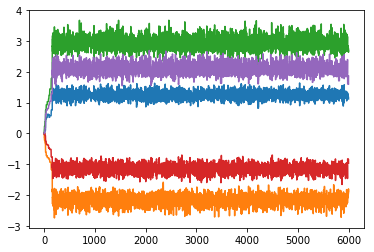

In [11]:
plt.plot(wSaved)

IndexError: index 5 is out of bounds for axis 1 with size 5

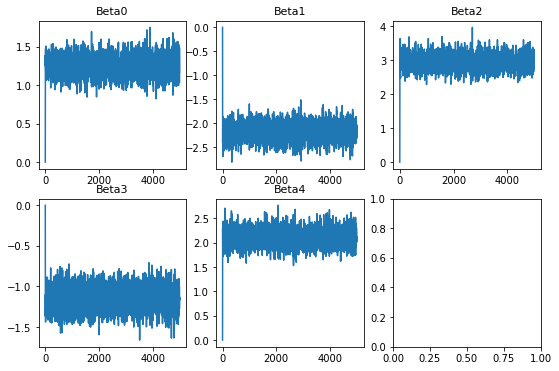

In [31]:

tot_plot_n = 5
fig, axes = plt.subplots(2,3,figsize = (9,6),sharey = False)
for i, ax in enumerate(axes.ravel(),1):
    ax.plot(wSaved[:,i-1])
    ax.set_title('Beta%d' % (i-1),fontsize = 11)
plt.tight_layout()


IndexError: index 5 is out of bounds for axis 1 with size 5

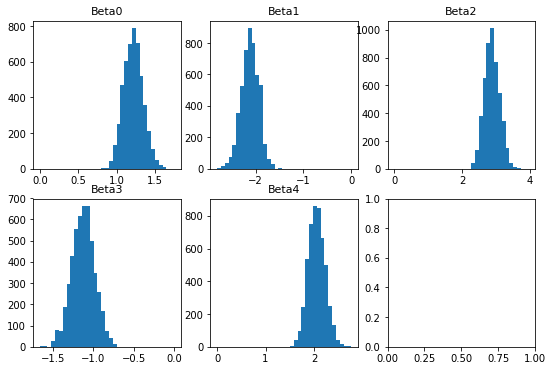

In [40]:

tot_plot_n = 5
fig, axes = plt.subplots(2,3,figsize = (9,6),sharey = False)
for i, ax in enumerate(axes.ravel(),1):
    ax.hist(wSaved[:,i-1],bins = 35)
    ax.set_title('Beta%d' % (i-1),fontsize = 11)
plt.tight_layout()
    # Designate the bin and then alpha is a transparency value.